# Test information status by context in Twitter
Let's test whether we can approximate information status based on broader context:

- appositive phrases, e.g. `San Juan, **which is in PR**`
- cooccurrence with larger entities `news from **Puerto Rico**: San Juan hit by hurricane`

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load data
Let's get all the event NE data and look for possible parse contexts.

In [2]:
from unidecode import unidecode
from ast import literal_eval
combined_NE_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', index_col=False, compression='gzip')
combined_NE_data.loc[:, 'NE'] = combined_NE_data.loc[:, 'NE'].apply(literal_eval)
combined_NE_data.loc[:, 'NE_fixed'] = combined_NE_data.loc[:, 'NE'].apply(lambda x: unidecode(x[0].lower()).replace('_', ' '))
display(combined_NE_data.head())

,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed
0,914031644784431110,RT @Scavino45: POTUS' @realDonaldTrump on Hurr...,maria,"(Hurricane, LOCATION)",False,False,hurricane
1,914033435756290048,RT @ReallyAmerican1: @robreiner Why is Trump j...,maria,"(island, LOCATION)",False,False,island
2,914034547251191809,RT @UKDefenceIrma: An update from yesterday on...,maria,"(Dominica, LOCATION)",False,False,dominica
3,914037164505288705,"AEE: ""5 pequeñas autoridades para energizar a ...",maria,"(Isla, LOCATION)",False,False,isla
4,914051722938601472,RT @christoq: A ‘Toddler-Level’ Response: Trum...,maria,"(Big_Water, LOCATION)",False,False,big water


In [54]:
import re
def build_name_regex(x):
    try:
        x_regex = re.compile('|'.join(['^%s$'%(y.lower()) for y in set([x.loc['name']]+str(x.loc['alternate_names']).split(',')) - set([''])]))
    except Exception as e:
        x_regex = ''
    return x_regex
# load geonames data for cooccurrence
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False)
# restrict to US-specific locations
loc_feat_codes=['PPL', 'PPLA', 'ADM1', 'ADM2', 'ADM3', 'ADM4', 'PPLL', 'PPLS', 'PPLG', 'PPLC', 'PPLX', 'SCH', 'CH', 'BLDG', 'CMTY', 'LCTY', 'ISL']
geonames_countries=['US', 'PR']
geonames_data.fillna('', inplace=True)
geonames_data_loc = geonames_data[geonames_data.loc[:, 'feature_code'].isin(loc_feat_codes)]
# restrict to features/countries
geonames_data_loc = geonames_data_loc[geonames_data_loc.loc[:, 'country'].isin(geonames_countries)]
geonames_data_loc.loc[:, 'name_regex'] = geonames_data_loc.apply(build_name_regex, axis=1)
print('%d valid possible GeoNames entries'%(geonames_data_loc.shape[0]))
## look for countries/states
state_codes = set(['ADM1'])
territory_codes = set(['PCLD'])
country_code = 'PCLI'
us_countries = set(['US'])
us_territory_countries = set(['US', 'PR'])
geonames_country_state = geonames_data[((geonames_data.loc[:, 'feature_code'].isin(state_codes)) & (geonames_data.loc[:, 'country'].isin(us_countries))) | 
                                       ((geonames_data.loc[:, 'feature_code'].isin(territory_codes)) & (geonames_data.loc[:, 'country'].isin(us_territory_countries))) |
                                       (geonames_data.loc[:, 'feature_code'] == country_code)]
geonames_country_state.loc[:, 'name_regex'] = geonames_country_state.apply(build_name_regex, axis=1)

945821 valid possible GeoNames entries


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
## get dict for pop/name lookup
## for all valid NE locations
valid_NE_loc = combined_NE_data[combined_NE_data.loc[:, 'valid_loc']]
print('%d/%d valid LOC'%(valid_NE_loc.shape[0], combined_NE_data.shape[0]))
valid_NE_loc_unique = valid_NE_loc.loc[:, 'name_fixed'].unique()
max_pop_dict = {x : geonames_name_data_loc[geonames_name_data_loc.loc[:, 'name_regex']] for x in valid_NE_loc_unique}

130862/511743 valid LOC


### Test parsing

Let's pick an easy example to start: `San Juan`.

In [3]:
print(combined_NE_data.loc[:, 'data_name_fixed'].value_counts())
print('%d/%d valid LOC NEs'%(combined_NE_data.loc[:, 'valid_loc'].sum(), combined_NE_data.shape[0]))

irma        227194
harvey      181636
maria        52559
florence     28555
michael      21799
Name: data_name_fixed, dtype: int64
130862/511743 valid LOC NEs


In [4]:
test_NE_name_i = 'san juan'
combined_NE_data_i = combined_NE_data[combined_NE_data.loc[:, 'data_name_fixed']=='maria'][combined_NE_data.loc[:, 'NE_fixed']==test_NE_name_i]
display(combined_NE_data_i.head())
top_k = 20
np.random.seed(123)
test_data_i = combined_NE_data_i.loc[np.random.choice(combined_NE_data_i.index, top_k, replace=False), :]
print(test_data_i.head())

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed
11,914098594285867009,RT @peterdaou: When Trump attacks San Juan's m...,maria,"(San_Juan, LOCATION)",True,False,san juan
12,914098850125754368,RT @kharyp: The petty thin skinned #DonaldTrum...,maria,"(San_Juan, LOCATION)",True,False,san juan
18,914100758550843393,RT @johnlundin: Unbelievable! This from the Pr...,maria,"(San_Juan, LOCATION)",True,False,san juan
20,914106160780804096,"RT @will_c_fischer: .@realDonaldTrump, the rev...",maria,"(San_Juan, LOCATION)",True,False,san juan
36,914115849635745792,RT @Mitch__Roy: The mayor of San Juan is compl...,maria,"(San_Juan, LOCATION)",True,False,san juan


                       id                                                txt  \
43645  913960975799169024  Mayor of San Juan pleads for Federal Help afte...   
27808  912545976061190145  San Juan, #PuertoRico is the #SamaritansPurse ...   
51075  915539269900554240  . @realDonaldTrump launches paper towels to pe...   
47838  915328579990323203  RT chefjoseandres: Quick report from #PuertoRi...   
176    914215552427716608  Who else thinks Donald Trump only just found o...   

      data_name_fixed                    NE  valid_loc  has_descriptor  \
43645           maria  (San_Juan, LOCATION)       True           False   
27808           maria  (San_Juan, LOCATION)       True           False   
51075           maria  (San_Juan, LOCATION)       True           False   
47838           maria  (San_Juan, LOCATION)       True           False   
176             maria  (San_Juan, LOCATION)       True           False   

       NE_fixed  
43645  san juan  
27808  san juan  
51075  san juan  
47

## Test parsing

Let's try to parse these example sentences using [TweeboParser](https://github.com/ikekonglp/TweeboParser).

According to [run.sh](https://github.com/ikekonglp/TweeboParser/blob/master/run.sh), we should output text to file with one tweet per line.

Update! `conair` doesn't have the right GCC compiler to run the parser? 

error: `./TurboParser: /usr/lib64/libstdc++.so.6: version "GLIBCXX_3.4.20" not found (required by ./TurboParser)`

Solution: spacy because it's lightweight.

In [5]:
import spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [6]:
from nltk.tokenize import sent_tokenize
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import build_parse, extract_full_tree, extract_NE_subtree
for idx, data_i_j in test_data_i.iterrows():
    doc_j = data_i_j.loc['txt']
    print('parsing text %s'%(doc_j))
    doc_j_sents = sent_tokenize(doc_j)
    doc_j_parses = [build_parse(spacy_nlp(x), parse_type='spacy') for x in doc_j_sents]
    doc_j_parse_trees = [extract_full_tree(x) for x in doc_j_parses]
#     print(doc_j_parses)
    NE_j = data_i_j.loc['NE'][0].replace('_', ' ')
    print('parsing subtree for NE %s'%(NE_j))
    tree_ctr = 0
    tree_token_ctr = 0
    NE_subtree, tree_ctr, tree_token_ctr = extract_NE_subtree(NE_j, doc_j_parses, doc_j_parse_trees, tree_ctr, tree_token_ctr)
    print(NE_subtree)

parsing text Mayor of San Juan pleads for Federal Help after Hurricane. #sanjuan #PuertoRico #HurricaneRelief <URL>

parsing subtree for NE San Juan
[]
parsing text San Juan, #PuertoRico is the #SamaritansPurse logistics hub for the multinational response across Caribbean–Team positioned there before Irma

parsing subtree for NE San Juan
[[',', 'PUNCT', 1, 'punct', 2], ['#', 'PROPN', 4, 'compound', 3], ['PuertoRico', 'PROPN', 1, 'appos', 4]]
parsing text . @realDonaldTrump launches paper towels to people @the Calvary Chapel Church near San Juan #HurricaneMaria #SanJuan <URL>

parsing subtree for NE San Juan
[]
parsing text RT chefjoseandres: Quick report from #PuertoRico : Our main WCKitchen operation is growing here in San Juan! Tomorr… <URL>

parsing subtree for NE San Juan
[]
parsing text Who else thinks Donald Trump only just found out the mayor of San Juan is a woman in the last 24hrs? #PuertoRico

parsing subtree for NE San Juan
[]
parsing text The Mayor of San Juan is currently 

This is working! Although the data are admittedly sparse. 

Let's get the children for all NEs in data and filter to appositive or other useful phrases.

In [ ]:
# %%capture parse_children_output
import spacy
from langid import langid
from data_helpers import build_parse, extract_full_tree, extract_NE_subtree
import numpy as np
np.random.seed(123)
spacy_nlp_en = spacy.load('en_core_web_sm')
spacy_nlp_es = spacy.load('es_core_news_sm')
NE_children_data = []
cutoff = 2000
combined_NE_data_rand = combined_NE_data.copy()
np.random.shuffle(combined_data_rand.values)
for i, (data_id_i, data_i) in enumerate(combined_NE_data_rand.groupby('id')):
    tree_ctr = 0
    tree_token_ctr = 0
    data_i_txt = data_i.loc[:, 'txt'].values[0]
#     print('parsing sentence %s'%(data_i_txt))
    # detect lang??
    data_i_lang = langid.classify(data_i_txt)[0]
    data_i.loc[:, 'lang'] = data_i_lang
    if(data_i_lang == 'es'):
        spacy_nlp_i = spacy_nlp_es
    else:
        spacy_nlp_i = spacy_nlp_en
    data_i_sents = sent_tokenize(data_i_txt)
    data_i_parses = [build_parse(spacy_nlp_i(x)) for x in data_i_sents]
    data_i_parse_trees = [extract_full_tree(x) for x in data_i_parses]
#     print('parses\n%s'%(str(data_i_parses)))
    tree_ctr = 0
    tree_token_ctr = 0
    NE_children_i = []
    for NE_j in data_i.loc[:, 'NE']:
        NE_j_str = NE_j[0].replace('_', ' ')
#         print('testing NE %s'%(NE_j_str))
        NE_subtree, tree_ctr, tree_token_ctr = extract_NE_subtree(NE_j_str, data_i_parses, data_i_parse_trees, tree_ctr, tree_token_ctr)
        NE_children_i.append(NE_subtree)
#     print('generated NE children\n%s'%(str(NE_children_i)))
#     if(any([len(x) > 0 for x in NE_children_i])):
#         print('found good children\n%s'%(str(NE_children_i)))
#         break
#     print('got children')
#     print(NE_children_i)
    data_i.loc[:, 'NE_children'] = pd.Series(NE_children_i, index=data_i.index)
#     print('updated data')
#     print(data_i)
    NE_children_data.append(data_i)
    if(i % 10 == 0):
        print('processed %d status groups'%(i))
    if(i >= cutoff):
        break
NE_children_df = pd.concat(NE_children_data, axis=0)
#     for NE_j in data_i.loc[:, 'NE']:
#         NE_j_str = NE_j[0].replace('_', ' ')

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


processed 0 status groups
processed 10 status groups
processed 20 status groups
processed 30 status groups


In [28]:
print(NE_children_df.shape)

(2510, 9)


In [35]:
# inspect some sample outputs
NE_valid_children_df = NE_children_df[NE_children_df.loc[:, 'NE_children'].apply(lambda x: len(x) > 0)]
print('%.3f%% valid children'%(NE_valid_children_df.shape[0] / NE_children_df.shape[0]*100))
display(NE_valid_children_df.head())

22.032% valid children


,id,txt,data_name_fixed,NE,valid_loc,has_descriptor,NE_fixed,lang,NE_children
52561,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,"(Martinique, LOCATION)",False,False,martinique,en,"[[,, PUNCT, 10, punct, 11], [St., PROPN, 13, c..."
52562,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,"(Barbados, LOCATION)",False,False,barbados,en,"[[,, PUNCT, 15, punct, 16], [and, CCONJ, 15, c..."
52564,898365718013595648,RT @NHC_Atlantic: Tropical Storm #Harvey Advis...,harvey,"(Windward_Islands, LOCATION)",False,False,windward islands,en,"[[the, DET, 15, det, 13]]"
52565,898379714406088704,Tropical Storm #Harvey Advisory 3: Harvey Near...,harvey,"(Windward_Islands, LOCATION)",False,False,windward islands,en,"[[the, DET, 11, det, 9]]"
52566,898382977574612992,RT @NHC_Atlantic: Tropical Storm #Harvey Advis...,harvey,"(Windward_Islands, LOCATION)",False,False,windward islands,en,"[[the, DET, 14, det, 12]]"


Let's look at the useful children, based on descriptor relationships.

Simple rule: identify child with the highest head index, and determine if the dependency label is one of the following.
- `relcl`, `acl`, `appos`, `amod`, `prep`

In [380]:
DESCRIPTOR_LABELS = ['relcl', 'acl', 'appos', 'prep']
def get_head_dep(children_list):
    head_child = max(children_list, key=lambda x: x[3])
    head_child_dep = head_child[3]
    return head_child_dep
NE_valid_children_with_descriptor_df = NE_valid_children_df[NE_valid_children_df.loc[:, 'NE_children'].apply(lambda x: get_head_dep(x) in DESCRIPTOR_LABELS)]
print('%.3f%% of children with descriptor'%(NE_valid_children_with_descriptor_df.shape[0] / NE_children_df.shape[0]*100))
display(NE_valid_children_with_descriptor_df.loc[:, ['NE', 'NE_children']].head(20).values)

1.355% of children with descriptor


array([[('Bay', 'LOCATION'),
        list([['of', 'ADP', 20, 'prep', 21], ['…', 'PUNCT', 21, 'pobj', 22]])],
       [('Caribbean_Sea', 'LOCATION'),
        list([['the', 'DET', 8, 'det', 5], ['western', 'ADJ', 8, 'amod', 6], ['or', 'CCONJ', 8, 'cc', 9], ['Bay', 'PROPN', 8, 'conj', 10], ['of', 'ADP', 10, 'prep', 11], ['Campeche', 'PROPN', 11, 'pobj', 12]])],
       [('Caribbean_Sea', 'LOCATION'),
        list([['the', 'DET', 10, 'det', 7], ['western', 'ADJ', 10, 'amod', 8], ['or', 'CCONJ', 10, 'cc', 11], ['Bay', 'PROPN', 10, 'conj', 12], ['of', 'ADP', 12, 'prep', 13], ['Campeche', 'PROPN', 13, 'pobj', 14]])],
       [('NW_Caribbean_Sea', 'LOCATION'),
        list([['the', 'DET', 16, 'det', 13], ['or', 'CCONJ', 16, 'cc', 17], ['Bay', 'PROPN', 16, 'conj', 18], ['of', 'ADP', 18, 'prep', 19], ['Campeche', 'PROPN', 19, 'pobj', 20]])],
       [('Texas', 'LOCATION'),
        list([['on', 'ADP', 3, 'prep', 4], ['watch', 'NOUN', 4, 'pobj', 5], ['for', 'ADP', 5, 'prep', 6], ['a', 'DET', 11, 'det'

These seem generally good! Although the coverage is sparse. 

Let's extract NE parents, e.g. "mayor of San Juan."

In [381]:
reload(data_helpers)
from data_helpers import extract_NE_supertree
for idx, data_i_j in test_data_i.iterrows():
    doc_j = data_i_j.loc['txt']
    print('parsing text %s'%(doc_j))
    doc_j_sents = sent_tokenize(doc_j)
    doc_j_parses = [build_parse(spacy_nlp(x), parse_type='spacy') for x in doc_j_sents]
    print('generated parses:\n%s'%('\n'.join([' ' .join(['/'.join(map(str, y)) for y in x]) for x in doc_j_parses])))
    doc_j_parse_trees = [extract_full_tree(x) for x in doc_j_parses]
#     print(doc_j_parses)
    NE_j = data_i_j.loc['NE'][0].replace('_', ' ')
    print('parsing supertree for NE %s'%(NE_j))
    tree_ctr = 0
    tree_token_ctr = 0
    NE_supertree, tree_ctr, tree_token_ctr = extract_NE_supertree(NE_j, doc_j_parses, doc_j_parse_trees, tree_ctr, tree_token_ctr)
    # get rid of ROOT in supertree
    
    print(NE_supertree)

parsing text Mayor of San Juan pleads for Federal Help after Hurricane. #sanjuan #PuertoRico #HurricaneRelief <URL>

generated parses:
Mayor/PROPN/4/nsubj/0 of/ADP/0/prep/1 San/PROPN/3/compound/2 Juan/PROPN/1/pobj/3 pleads/VERB/4/ROOT/4 for/ADP/4/prep/5 Federal/PROPN/7/compound/6 Help/PROPN/5/pobj/7 after/ADP/7/prep/8 Hurricane/PROPN/8/pobj/9 ./PUNCT/4/punct/10
#/NOUN/7/nmod/0 sanjuan/NOUN/7/compound/1 #/SYM/3/nmod/2 PuertoRico/PROPN/7/nmod/3 #/PROPN/5/nmod/4 HurricaneRelief/PROPN/3/appos/5 </X/7/nmod/6 URL/PROPN/7/ROOT/7 >/X/7/appos/8
parsing supertree for NE San Juan
[['Mayor', 'PROPN', 4, 'nsubj', 0], ['of', 'ADP', 0, 'prep', 1], ['pleads', 'VERB', 4, 'ROOT', 4]]
parsing text San Juan, #PuertoRico is the #SamaritansPurse logistics hub for the multinational response across Caribbean–Team positioned there before Irma

generated parses:
San/PROPN/1/compound/0 Juan/PROPN/5/nsubj/1 ,/PUNCT/1/punct/2 #/PROPN/4/compound/3 PuertoRico/PROPN/1/appos/4 is/VERB/5/ROOT/5 the/DET/10/det/6 #/SYM/8

generated parses:
@LesterHoltNBC/PROPN/1/nsubj/0 was/VERB/1/ROOT/1 1st/ADJ/3/amod/2 reporter/NOUN/1/attr/3 2/NUM/5/compound/4 b/NOUN/3/appos/5 where/ADV/10/advmod/6 #/SYM/8/compound/7 Maria/PROPN/10/nsubj/8 first/ADV/10/advmod/9 touched/VERB/3/relcl/10 dwn/NOUN/10/dobj/11 ../PUNCT/1/punct/12 #/SYM/16/nmod/13 Naguabo/PROPN/16/compound/14 #/SYM/16/compound/15 PuertoRico/PROPN/19/nsubj/16 everybody/NOUN/16/appos/17 else/ADV/17/advmod/18 was/VERB/19/ROOT/19 in/ADP/19/prep/20 San/PROPN/22/compound/21 Juan/PROPN/20/pobj/22 or/CCONJ/20/cc/23 in/ADP/20/conj/24 S.J./PROPN/24/pobj/25
area/NOUN/0/ROOT/0 ./PUNCT/0/punct/1
</X/1/nmod/0 URL/NOUN/1/ROOT/1 >/X/1/appos/2
parsing supertree for NE San Juan
[['was', 'VERB', 19, 'ROOT', 19], ['in', 'ADP', 19, 'prep', 20]]
parsing text People who are so dumb they think Soros sent San Juan mayor Carmen Yulin Cruz a t-shirt will be the death of civilization. #PuertoRico

generated parses:
People/NOUN/6/nsubj/0 who/NOUN/2/nsubj/1 are/VERB/0/relcl/2 so/ADV/4/ad

### Test descriptors in full parse data

Having parsed all the tweet data ([here](parse_twitter_data.py)), let's take a look for descriptors.

We need to assess precision first! How many of these descriptors mark the NE as new information?

In [392]:
from ast import literal_eval
import pandas as pd
combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', index_col=False, compression='gzip')
display(combined_tag_data.head())
# parses
combined_parse_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data_parsed.gz', sep='\t', index_col=False, converters={'parse':literal_eval})
display(combined_parse_data.head())

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,has_descriptor,NE_fixed
0,914030327777067008,RT @chefjoseandres: Quick update from #PuertoR...,maria,EmeraidKatNJ,2017-09-30 07:33:06,en,NaN,NaN,False,False,False,NaN
1,914031326042435584,#Support #Purchase @X_RATED25 Single (#DontHa...,maria,X_RATED25,2017-09-30 07:37:04,en,NaN,NaN,False,False,False,NaN
2,914031644784431110,RT @Scavino45: POTUS' @realDonaldTrump on Hurr...,maria,D_McCaughan,2017-09-30 07:38:20,en,POTUS,PERSON,False,False,False,potus
3,914031644784431110,RT @Scavino45: POTUS' @realDonaldTrump on Hurr...,maria,D_McCaughan,2017-09-30 07:38:20,en,Hurricane,LOCATION,True,False,False,hurricane
4,914031795787763713,RT @altNOAA: .@realDonaldTrump If you can't ge...,maria,eccolabella,2017-09-30 07:38:56,en,NaN,NaN,False,False,False,NaN


,parse,id
0,"[[BREAKING, , 0, ROOT, 0], [:, , 0, punct, 1],...",906899441763975168
1,"[[Well, , 1, intj, 0], [said, , 1, ROOT, 1], [...",906899440467894272
2,"[[#, , 1, nmod, 0], [HurricaneIrma, , 3, nmod,...",906899440467894272
3,"[[Not, , 1, neg, 0], [one, , 2, nummod, 1], [c...",906899440379850752
4,"[[The, , 1, det, 0], [money, , 3, nsubj, 1], [...",906899440379850752


In [396]:
# combine parse data
combined_tag_parse_data = pd.merge(combined_tag_data, combined_parse_data, on='id')
# look at parses for valid_loc NEs
combined_tag_parse_data_loc_valid = combined_tag_parse_data[combined_tag_parse_data.loc[:, 'valid_loc']]
print('%d/%d valid data'%(combined_tag_parse_data_loc_valid.shape[0], combined_tag_parse_data.shape[0]))

155514/2740403 valid data


In [410]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_full_tree, extract_NE_subtree
# extract descriptor children
def extract_children_from_full_data(data):
    children_data = []
    for id_i, data_i in data.groupby('id'):
        data_i_parses = list(data_i.loc[:, 'parse'].values)
        data_i_parse_trees = [extract_full_tree(x) for x in data_i_parses]
        tree_ctr = 0
        tree_token_ctr = 0
        children_data_i = []
        for NE_j in data_i.loc[:, 'NE'].values:
            NE_j_str = NE_j.replace('_', ' ')
            NE_subtree, tree_ctr, tree_token_ctr = extract_NE_subtree(NE_j_str, data_i_parses, data_i_parse_trees, tree_ctr, tree_token_ctr)
            children_data_i.append(NE_subtree)
        children_data_i = pd.Series(children_data_i, index=data_i.index)
        children_data.append(children_data_i)
    children_data = pd.concat(children_data, axis=0)
#     display(children_data.head())
    return children_data
combined_tag_parse_data_loc_valid.loc[:, 'children'] = extract_children_from_full_data(combined_tag_parse_data_loc_valid)
# determine descriptor children based on head dependency relationship
def get_head_dep(children_list):
    head_child = max(children_list, key=lambda x: x[3])
    head_child_dep = head_child[3]
    return head_child_dep
DESCRIPTOR_HEADS = ['relcl', 'acl', 'appos', 'prep']
def is_head_dep_descriptor(children_list):
    if(len(children_list) > 0):
        dep = get_head_dep(children_list)
        return dep in DESCRIPTOR_HEADS
    else:
        return False
combined_tag_parse_data_loc_valid.loc[:, 'has_parse_descriptor'] = combined_tag_parse_data_loc_valid.loc[:, 'children'].apply(is_head_dep_descriptor)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [412]:
print('%.3f%% of all tweets with possible descriptor'%(combined_tag_parse_data_loc_valid.loc[:, 'has_parse_descriptor'].sum() / combined_tag_parse_data_loc_valid.shape[0] * 100))
print('%.3f%% of all tweets with actual descriptor'%(combined_tag_parse_data_loc_valid.loc[:, 'has_descriptor'].sum() / combined_tag_parse_data_loc_valid.shape[0]*100))

0.810% of all tweets with possible descriptor
9.460% of all tweets with actual descriptor


Look at a subsample of tweets with children and determine if children mark new/old information status.

In [421]:
np.random.seed(123)
# print(np.random.choice(combined_tag_parse_data_loc_valid.index, size=20, replace=False))
# print([x in combined_tag_parse_data_loc_valid.index for x in np.random.choice(combined_tag_parse_data_loc_valid.index, size=20, replace=False)])
top_k = 20
combined_tag_parse_data_loc_valid_samp = combined_tag_parse_data_loc_valid[combined_tag_parse_data_loc_valid.loc[:, 'has_parse_descriptor']]
combined_tag_parse_data_loc_valid_samp = combined_tag_parse_data_loc_valid_samp.loc[np.random.choice(combined_tag_parse_data_loc_valid_samp.index, size=top_k, replace=False), :]
display(combined_tag_parse_data_loc_valid_samp.head())
for idx_i, data_i in combined_tag_parse_data_loc_valid_samp.iterrows():
    print('full txt %s'%(data_i.loc['txt']))
    print('NE %s'%(data_i.loc['NE']))
    print('children %s'%(str(data_i.loc['children'])))

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,has_descriptor,NE_fixed,parse,children,has_parse_descriptor
2171980,907737662823440384,Miami Beach after #afterirma #irma #Miami #Flo...,irma,volvoshine,2017-09-12 18:48:18,en,Miami_Beach,LOCATION,True,True,False,miami_beach,"[[Miami, , 1, compound, 0], [Beach, , 1, ROOT,...","[[after, , 1, prep, 2], [#, , 12, nmod, 3], [a...",True
908297,902009086409039872,Houston & Texas in our prayers met a lot of ni...,harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-27 23:24:00,en,Houston,LOCATION,True,True,False,houston,"[[Houston, , 6, nsubj, 0], [&, , 0, cc, 1], [T...","[[&, , 0, cc, 1], [Texas, , 0, conj, 2], [in, ...",True
2182620,907669868987777024,Atlanta today following #Irma <URL>,irma,amandatperera,2017-09-12 14:18:55,en,Atlanta,LOCATION,True,True,False,atlanta,"[[Atlanta, , 0, ROOT, 0], [today, , 0, npadvmo...","[[today, , 0, npadvmod, 1], [following, , 0, p...",True
1145136,903383281726627840,Peace with Christ Lutheran Church is hosting a...,harvey,"#Irma,#HurricaneIrma,#Harvey,#HurricaneHarvey_...",2017-08-31 18:25:00,en,Peace,LOCATION,True,True,False,peace,"[[Peace, , 6, nsubj, 0], [with, , 0, prep, 1],...","[[with, , 0, prep, 1], [Christ, , 4, compound,...",True
2558179,1044697282871021568,"Monday night, nearly 2,000 people stayed in 36...",florence,RedCross,2018-09-25 21:16:56,en,Red_Cross,LOCATION,True,True,False,red_cross,"[[Monday, , 1, compound, 0], [night, , 6, npad...","[[36, , 10, nummod, 8], [and, , 10, cc, 11], [...",True


full txt Miami Beach after #afterirma #irma #Miami #Florida <URL>
NE Miami_Beach
children [['after', '', 1, 'prep', 2], ['#', '', 12, 'nmod', 3], ['afterirma', '', 12, 'amod', 4], ['#', '', 12, 'nmod', 5], ['irma', '', 12, 'compound', 6], ['#', '', 12, 'nmod', 7], ['Miami', '', 12, 'nmod', 8], ['#', '', 10, 'nmod', 9], ['Florida', '', 12, 'nmod', 10], ['<', '', 12, 'nmod', 11], ['URL', '', 2, 'pobj', 12], ['>', '', 1, 'appos', 13]]
full txt Houston & Texas in our prayers met a lot of nice people when we lived there in 2015-6. #HurricaneHarvey <URL>
NE Houston
children [['&', '', 0, 'cc', 1], ['Texas', '', 0, 'conj', 2], ['in', '', 0, 'prep', 3], ['our', '', 5, 'poss', 4], ['prayers', '', 3, 'pobj', 5]]
full txt Atlanta today following #Irma <URL>
NE Atlanta
children [['today', '', 0, 'npadvmod', 1], ['following', '', 0, 'prep', 2], ['#', '', 4, 'nmod', 3], ['Irma', '', 2, 'pobj', 4], ['<', '', 6, 'nmod', 5], ['URL', '', 4, 'appos', 6], ['>', '', 0, 'appos', 7]]
full txt Peace with Chri

Actual descriptors:

- `Wrightsville Beach in North Carolina`
- `Canyon at Brazos`
- `Vineyards in Naples`

So maybe 15% of assumed descriptors are actual children. This puts us at about 15% x 0.8% = 0.012% of NE mentions ~ a few hundred. Not great!!

TL;DR parsing is probably not going to help us here!

TODO: it's worth investigating the presence of parent descriptors, e.g. "Puerto Rico's San Juan".

### Test entity cooccurrence
Test how often a LOCATION NE cooccurs with a larger NE, using exact string matching from a given list of larger entities (state, country). 

We'll use the GeoNames data that we obtained earlier and look for several kinds of cooccurrence:

- coocurrence of LOCATION with country/state LOCATION
- cooccurrence of LOCATION with more important LOCATION (based on `max_pop` and `max_names`)

In [74]:
from unidecode import unidecode
import pandas as pd
def load_geonames_data(geonames_data_file, loc_feat_codes=['PPL', 'PPLA', 'ADM1', 'ADM2', 'ADM3', 'ADM4', 'PPLL', 'PPLS', 'PPLG', 'PPLC', 'PPLX', 'SCH', 'CH', 'BLDG', 'CMTY', 'LCTY', 'ISL'], geonames_countries=['US', 'PR']):
    """
    Load relevant GeoNames data from file.

    :param geonames_data_file: data file
    :returns geonames_data_loc:: relevant location data (based on feature codes, countries)
    :return geonames_country_state:: countries/states to leave out of location matching
    """
    geonames_data = pd.read_csv(geonames_data_file, sep='\t', index_col=False, usecols=['geonames_ID', 'name', 'alternate_names', 'feature_code', 'country', 'latitude', 'longitude', 'alternate_name_count', 'population'])
    geonames_data.rename(columns={'geonames_ID':'id'}, inplace=True)
    geonames_data.fillna('', inplace=True)
    geonames_data_loc = geonames_data[geonames_data.loc[:, 'feature_code'].isin(loc_feat_codes)]
    # restrict to features/countries
    geonames_data_loc = geonames_data_loc[geonames_data_loc.loc[:, 'country'].isin(geonames_countries)]
    # match each location name to GeoNames entry
    # using regex of alternate names
    geonames_data_loc.loc[:, 'name_regex'] = geonames_data_loc.apply(lambda x: build_name_regex(x), axis=1)
    geonames_data_loc = geonames_data_loc[geonames_data_loc.loc[:, 'name_regex'] != '']
    # get country/state names for filtering
    state_codes = set(['ADM1'])
    territory_codes = set(['PCLD'])
    country_code = 'PCLI'
    us_countries = set(['US'])
    us_territory_countries = set(['US', 'PR'])
    geonames_country_state = geonames_data[((geonames_data.loc[:, 'feature_code'].isin(state_codes)) & (geonames_data.loc[:, 'country'].isin(us_countries))) | 
                                                ((geonames_data.loc[:, 'feature_code'].isin(territory_codes)) & (geonames_data.loc[:, 'country'].isin(us_territory_countries))) |
                                                (geonames_data.loc[:, 'feature_code'] == country_code)]
    geonames_country_state.loc[:, 'name_regex'] = geonames_country_state.apply(build_name_regex, axis=1)
    return geonames_data_loc, geonames_country_state

In [75]:
import pandas as pd
import pickle
# test with data 
combined_tag_data = pd.read_csv('../../data/mined_tweets/combined_tweet_NE_flat_data.gz', sep='\t', index_col=False, compression='gzip')
# limit to location-tagged data
LOC_TYPES = set(['CITY', 'LOCATION'])
combined_tag_data_loc = combined_tag_data[(combined_tag_data.loc[:, 'NE'] != '') & (combined_tag_data.loc[:, 'NE_type'].isin(LOC_TYPES))]
geonames_data_loc, geonames_country_state = load_geonames_data('/hg190/corpora/GeoNames/allCountriesSimplified.tsv')
# regenerate geo_dict...BAD IDEA
# combined_tag_data_NE_names = combined_tag_data_loc.loc[:, 'NE_fixed'].unique()
# geo_dict = {x: geonames_data_loc[geonames_data_loc.loc[:, 'name_regex'].apply(lambda y: y.search(x) is not None)] for x in combined_tag_data_NE_names}
# generated when combining tagged data
geo_dict = pickle.load(open('../../data/mined_tweets/combined_data_NE_tweets_geo_dict.pickle', 'rb'))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [245]:
geo_dict_df = pd.concat([v.assign(name_fixed=k) for k,v in geo_dict.items()], axis=0)
print('%d geo_dict entries'%(geo_dict_df.shape[0]))
## merge with full data
importance_stat_names = ['population', 'alternate_name_count']
add_cols = ['name', 'latitude', 'longitude'] + importance_stat_names
geo_dict_df = pd.merge(geo_dict_df, geonames_data_loc.loc[:, add_cols], on=['name', 'latitude', 'longitude'], how='inner')
print('%d geo_dict entries'%(geo_dict_df.shape[0]))
geo_dict_complete = {k:v for k,v in geo_dict_df.groupby('name_fixed')}
## get dicts for importance stats
max_pop_dict = {k : v.loc[:, 'population'].max() for k,v in geo_dict_complete.items()}
max_names_dict = {k : v.loc[:, 'alternate_name_count'].max() for k,v in geo_dict_complete.items()}
## we can just do a join on the matching names! god I amaze myself sometimes
max_pop_df = pd.DataFrame(pd.Series(max_pop_dict), columns=['max_pop'])
max_names_df = pd.DataFrame(pd.Series(max_names_dict), columns=['max_names'])
max_pop_df.loc[:, 'NE_fixed'] = [x.replace(' ', '_') for x in max_pop_df.index]
max_names_df.loc[:, 'NE_fixed'] = [x.replace(' ', '_') for x in max_names_df.index]
max_pop_df.index = np.arange(max_pop_df.shape[0])
max_names_df.index = np.arange(max_names_df.shape[0])

48991 geo_dict entries
49007 geo_dict entries


In [94]:
test_name_i = 'san juan'
print(max_pop_dict[test_name_i])
print(max_names_dict[test_name_i])

431285
58


Assign every NE in data a `max_pop` or `max_names` value if available.

In [250]:
## add importance stats to all NE data!
combined_tag_data_loc_importance = combined_tag_data_loc.copy()
combined_tag_data_loc_importance = pd.merge(combined_tag_data_loc_importance, max_pop_df, on='NE_fixed', how='left')
combined_tag_data_loc_importance = pd.merge(combined_tag_data_loc_importance, max_names_df, on='NE_fixed', how='left')

In [153]:
# missing NEs in dict?
unique_NEs = combined_tag_data_loc.loc[:, 'NE_fixed'].apply(lambda x: x.replace('_', ' ')).unique()
missing_NEs = set(unique_NEs) - set(max_pop_dict.keys())
print('%d/%d missing NEs'%(len(missing_NEs), len(unique_NEs)))
print('%d/%d statuses affected by missing NEs'%(combined_tag_data_loc[combined_tag_data_loc.loc[:, 'NE_fixed'].isin(missing_NEs)].shape[0], combined_tag_data_loc.shape[0]))
print(sorted(missing_NEs)[100:110])
# TODO: remove quotes from NEs!!!

12451/19259 missing NEs
41136/511743 statuses affected by missing NEs
['"god', '"greater houston', '"guam', '"haiti', '"hardin county', '"harris county', '"harvey', '"haynes', '"hillsborough county', '"horry county']


In [332]:
from time import time
def extract_cooccurrence(data, geonames_country_state):
    """
    For each NE in data, determine if NE occurs with (1) country/state or (2) LOCATION with higher max_pop/max_names.
    
    # TODO: restrict candidates in max_pop, max_names dicts
    # based on event geography
    
    :param data: data with all NEs from a given status
    :param geonames_country_state: set of all country and U.S. state names
    :param max_pop_dict: dict with name/pop pairs
    :param max_names_dict: dict with name/name count pairs 
    :returns data:: updated data with cooccurrence (binary)
    """
    # determine if state/country occurs in text
    txt_clean = unidecode(data.loc[:, 'txt'].iloc[0].lower())
#     country_state_occur = np.any(data.loc[:, 'NE_fixed'].apply(lambda x: geonames_country_state.loc[:, 'name_regex'].apply(lambda y: y.search(x) is not None)))
    data = data.assign(country_state_cooccur=np.any(data.loc[:, 'NE_fixed'].apply(lambda x: x in geonames_country_state)))
    data_max_pop = data.loc[:, 'max_pop'].max()
    data_max_names = data.loc[:, 'max_names'].max()
    data = data.assign(max_pop_cooccur=data.loc[:, 'max_pop'] < data_max_pop)
    data = data.assign(max_names_cooccur=data.loc[:, 'max_names'] < data_max_names)
    # also compute importance difference!
    data = data.assign(max_pop_diff=data_max_pop-data.loc[:, 'max_pop'])
    data = data.assign(max_names_diff=data_max_names-data.loc[:, 'max_names'])
    return data

In [253]:
import re
from unidecode import unidecode
from functools import reduce
# display(geonames_country_state.head())
geonames_country_state_set = list(reduce(lambda x,y: x | y, geonames_country_state.apply(lambda x: set([unidecode(x.loc['name'].lower())] + unidecode(x.loc['alternate_names'].lower()).split(',')), axis=1)))
# include only ASCII names
ascii_matcher = re.compile('^[a-z\-]+$')
geonames_country_state_set = set([x for x in geonames_country_state_set if ascii_matcher.search(x) is not None])
# replace spaces
geonames_country_state_set = set([x.replace(' ', '_') for x in geonames_country_state_set])
print(len(geonames_country_state_set))

13155


In [277]:
from time import time
# test on toy data
id_counts = combined_tag_data_loc_importance.loc[:, 'id'].value_counts()
print('%d/%d statuses with >1 NE'%(len(id_counts[id_counts > 1]), combined_tag_data_loc_importance.shape[0]))
test_id_i = id_counts[id_counts > 1].index[15]
data_i = combined_tag_data_loc_importance[combined_tag_data_loc_importance.loc[:, 'id'] == test_id_i]
display(data_i)
# data_updated_i = extract_cooccurrence(data_i, geonames_country_state, max_pop_dict, max_names_dict)
start_time = time()
data_updated_i = extract_cooccurrence(data_i, geonames_country_state_set)
print('update time %.3f sec'%(time() - start_time))
display(data_updated_i)

77967/511743 statuses with >1 NE


,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,has_descriptor,NE_fixed,max_pop,max_names
511368,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,ALERT,LOCATION,True,True,False,alert,0.0,5.0
511369,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Greensboro,LOCATION,True,True,True,greensboro,285342.0,30.0
511370,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0
511371,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Gretna,LOCATION,True,True,True,gretna,5046.0,8.0
511372,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0
511373,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Quincy,LOCATION,True,False,True,quincy,93618.0,25.0
511374,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0
511375,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Seminole_County,LOCATION,True,True,True,seminole_county,422718.0,34.0
511376,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,GA,LOCATION,True,False,False,ga,8975842.0,19.0
511377,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Iredell_County,LOCATION,True,False,True,iredell_county,159437.0,37.0


update time 0.005 sec


,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,has_descriptor,NE_fixed,max_pop,max_names,country_state_coocur,max_pop_cooccur,max_names_cooccur
511368,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,ALERT,LOCATION,True,True,False,alert,0.0,5.0,True,True,True
511369,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Greensboro,LOCATION,True,True,True,greensboro,285342.0,30.0,True,True,True
511370,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0,True,False,True
511371,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Gretna,LOCATION,True,True,True,gretna,5046.0,8.0,True,True,True
511372,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0,True,False,True
511373,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Quincy,LOCATION,True,False,True,quincy,93618.0,25.0,True,True,True
511374,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,FL,LOCATION,True,False,False,fl,17671452.0,76.0,True,False,True
511375,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Seminole_County,LOCATION,True,True,True,seminole_county,422718.0,34.0,True,True,True
511376,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,GA,LOCATION,True,False,False,ga,8975842.0,19.0,True,True,True
511377,1050486573974867979,ALERT: Six people killed so far in #HurricaneM...,michael,TPFNewsDesk,2018-10-11 20:41:30,en,Iredell_County,LOCATION,True,False,True,iredell_county,159437.0,37.0,True,True,True


It works! All smaller entities are marked as cooccurring with a larger entity. And up to 10% of the data could be covered!!

In [281]:
combined_tag_data_loc_cooccur = []
cooccur_ctr = 0
for id_i, data_i in combined_tag_data_loc_importance.groupby('id'):
    if(data_i.shape[0] > 0):
        data_i = extract_cooccurrence(data_i, geonames_country_state_set)
        cooccur_ctr += 1
        if(cooccur_ctr % 1000 == 0):
            print('processed %d cooccur statuses'%(cooccur_ctr))
    combined_tag_data_loc_cooccur.append(data_i)
combined_tag_data_loc_cooccur = pd.concat(combined_tag_data_loc_cooccur, axis=0)
display(combined_tag_data_loc_cooccur.head())

processed 1000 cooccur statuses
processed 2000 cooccur statuses
processed 3000 cooccur statuses
processed 4000 cooccur statuses
processed 5000 cooccur statuses
processed 6000 cooccur statuses
processed 7000 cooccur statuses
processed 8000 cooccur statuses
processed 9000 cooccur statuses
processed 10000 cooccur statuses
processed 11000 cooccur statuses
processed 12000 cooccur statuses
processed 13000 cooccur statuses
processed 14000 cooccur statuses
processed 15000 cooccur statuses
processed 16000 cooccur statuses
processed 17000 cooccur statuses
processed 18000 cooccur statuses
processed 19000 cooccur statuses
processed 20000 cooccur statuses
processed 21000 cooccur statuses
processed 22000 cooccur statuses
processed 23000 cooccur statuses
processed 24000 cooccur statuses
processed 25000 cooccur statuses
processed 26000 cooccur statuses
processed 27000 cooccur statuses
processed 28000 cooccur statuses
processed 29000 cooccur statuses
processed 30000 cooccur statuses
processed 31000 coo

processed 246000 cooccur statuses
processed 247000 cooccur statuses
processed 248000 cooccur statuses
processed 249000 cooccur statuses
processed 250000 cooccur statuses
processed 251000 cooccur statuses
processed 252000 cooccur statuses
processed 253000 cooccur statuses
processed 254000 cooccur statuses
processed 255000 cooccur statuses
processed 256000 cooccur statuses
processed 257000 cooccur statuses
processed 258000 cooccur statuses
processed 259000 cooccur statuses
processed 260000 cooccur statuses
processed 261000 cooccur statuses
processed 262000 cooccur statuses
processed 263000 cooccur statuses
processed 264000 cooccur statuses
processed 265000 cooccur statuses
processed 266000 cooccur statuses
processed 267000 cooccur statuses
processed 268000 cooccur statuses
processed 269000 cooccur statuses
processed 270000 cooccur statuses
processed 271000 cooccur statuses
processed 272000 cooccur statuses
processed 273000 cooccur statuses
processed 274000 cooccur statuses
processed 2750

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,has_descriptor,NE_fixed,max_pop,max_names,country_state_coocur,max_pop_cooccur,max_names_cooccur,max_pop_diff,max_names_diff
52559,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43,en,Leeward_Islands,LOCATION,True,False,False,leeward_islands,0.0,4.0,True,True,True,17671452.0,72.0
52560,898303352928436226,RT @FloridaStorms: Tropical Storm #Harvey form...,harvey,wusfschreiner,2017-08-17 21:59:43,en,Florida,LOCATION,True,False,False,florida,17671452.0,76.0,True,False,False,0.0,0.0
52561,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25,en,Martinique,LOCATION,True,False,False,martinique,NaN,NaN,True,False,False,NaN,NaN
52562,898309317232873472,RT @NHC_Atlantic: Tropical storm warnings are ...,harvey,edwardpeguero1,2017-08-17 22:23:25,en,Barbados,LOCATION,True,False,False,barbados,1807.0,3.0,True,False,False,0.0,0.0
52563,898357862111612928,RT @NWSKeyWest: Tropical Storm #Harvey is movi...,harvey,coty_sandangel4,2017-08-18 01:36:19,en,Windward_islands,LOCATION,True,False,False,windward_islands,NaN,NaN,False,False,False,NaN,NaN


In [370]:
# save to file!!
combined_tag_data_loc_cooccur.to_csv('../../data/mined_tweets/combined_tweet_NE_flat_data_cooccur.gz', sep='\t', index=False, compression='gzip')

In [292]:
print('%d/%d valid locations'%(combined_tag_data_loc_cooccur.loc[:, 'valid_loc'].sum(), combined_tag_data_loc_cooccur.shape[0]))
combined_tag_data_loc_cooccur_valid = combined_tag_data_loc_cooccur[combined_tag_data_loc_cooccur.loc[:, 'valid_loc']]

130862/511743 valid locations


In [296]:
# add date
import dateutil
from datetime import datetime
combined_tag_data_loc_cooccur_valid.loc[:, 'date_stamp'] = combined_tag_data_loc_cooccur_valid.loc[:, 'date'].apply(lambda x: dateutil.parser.parse(x).timestamp())

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Process:

- Bin each data set by time.
- Compute $P(NE) = \frac{count(NE)}{\sum_{w}\:count(w)}$ based on total term frequency within each bin.
- Compute $P(NE, cooccur) = \frac{count(NE, cooccur)}{count(NE)}$

In [285]:
from nltk.tokenize.casual import TweetTokenizer
def bin_data_by_time(data, N_bins=5, data_name_col='data_name_fixed', date_col='date_stamp'):
    data_time = []
    for data_name_i, data_i in data.groupby(data_name_col):
        # fixed-width
        date_bins = np.linspace(data_i.loc[:, date_col].min(), data_i.loc[:, date_col].max()+1., num=N_bins+1)
        data_i.loc[:, 'date_stamp_bin'] = np.digitize(data_i.loc[:, date_col], date_bins)
        # drop duplicates within bin!!
        # why would we do this??
#         data_i.drop_duplicates('id', inplace=True)
#         data_i.drop_duplicates('txt', inplace=True)
        # add date_stamp_bin_min as start-date for each date_stamp_bin
        date_stamp_min = pd.DataFrame(data_i.groupby('date_stamp_bin').apply(lambda x: x.loc[:, date_col].min()), columns=['date_stamp_bin_min'])
        date_stamp_min.loc[:, 'date_stamp_bin'] = date_stamp_min.index
        data_i = pd.merge(data_i, date_stamp_min, on='date_stamp_bin')
        data_time.append(data_i)
    data_time = pd.concat(data_time)
    return data_time
TKNZR = TweetTokenizer()
def compute_bin_tf(data, data_name_col='data_name_fixed', data_time_col='date_stamp_bin'):
    data_tf = []
    for (data_name_i, data_time_i), data_i in data.groupby([data_name_col, data_time_col]):
        data_i.drop_duplicates('id', inplace=True)
        data_i_tokens = data_i.loc[:, 'txt'].apply(lambda x: TKNZR.tokenize(x))
        data_i_token_count = data_i_tokens.apply(lambda x: len(x)).sum()
        data_tf.append([data_name_i, data_time_i, data_i_token_count])
    data_tf = pd.DataFrame(data_tf, columns=[data_name_col, data_time_col, 'tf'])
    return data_tf

In [297]:
N_bins = 5
combined_tag_data_loc_time = bin_data_by_time(combined_tag_data_loc_cooccur_valid, N_bins=N_bins)
combined_tag_data_time_tf = compute_bin_tf(combined_tag_data_loc_time)
combined_tag_data_loc_time = pd.merge(combined_tag_data_loc_time, combined_tag_data_time_tf, on=['data_name_fixed', 'date_stamp_bin'])

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'date_stamp_bin' is both an index level and a column label.
Defau

In [334]:
# compute P(NE)
combined_tag_data_NE_tf = combined_tag_data_loc_time.groupby(['data_name_fixed', 'date_stamp_bin', 'NE_fixed']).apply(lambda x: x.shape[0] / x.loc[:, 'tf'].iloc[0]).reset_index()
combined_tag_data_NE_tf.rename(columns={0:'tf'}, inplace=True)
# add 0 vals for null dates
def add_date_bins(data, date_bins, NE_col='NE_fixed', data_name_col='data_name_fixed', date_time_col='date_stamp_bin', data_val_col='tf', null_data_val=0.):
    missing_dates = set(date_bins) - set(data.loc[:, date_time_col].unique())
    if(len(missing_dates) > 0):
        data_name = data.loc[:, data_name_col].iloc[0]
        NE = data.loc[:, NE_col].iloc[0]
        data_missing = pd.DataFrame([[x, NE, null_data_val, data_name] for x in missing_dates], columns=[date_time_col, NE_col, data_val_col, data_name_col])
        data = pd.concat([data, data_missing], axis=0)
    return data
date_bins = combined_tag_data_loc_time.loc[:, 'date_stamp_bin'].unique()
combined_tag_data_NE_tf = pd.concat([add_date_bins(x, date_bins) for i, x in combined_tag_data_NE_tf.groupby('NE_fixed')])
# compute P(NE, cooccur)
combined_tag_data_NE_country_state_cooccur = combined_tag_data_loc_time.groupby(['data_name_fixed', 'date_stamp_bin', 'NE_fixed']).apply(lambda x: x.loc[:, 'country_state_cooccur'].sum() / x.shape[0]).reset_index().rename(columns={0:'P(NE, country_state)'}, inplace=False)
combined_tag_data_NE_max_pop_cooccur = combined_tag_data_loc_time.groupby(['data_name_fixed', 'date_stamp_bin', 'NE_fixed']).apply(lambda x: x.loc[:, 'max_pop_cooccur'].sum() / x.shape[0]).reset_index().rename(columns={0:'P(NE, higher_pop_NE)'}, inplace=False)
combined_tag_data_NE_max_names_cooccur = combined_tag_data_loc_time.groupby(['data_name_fixed', 'date_stamp_bin', 'NE_fixed']).apply(lambda x: x.loc[:, 'max_names_cooccur'].sum() / x.shape[0]).reset_index().rename(columns={0:'P(NE, higher_names_NE)'}, inplace=False)

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


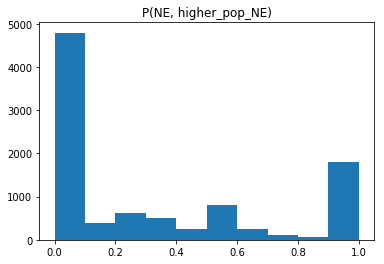

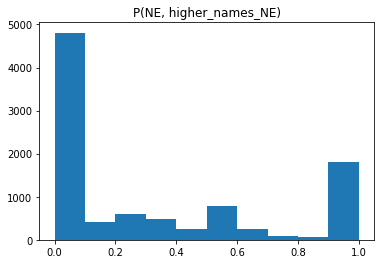

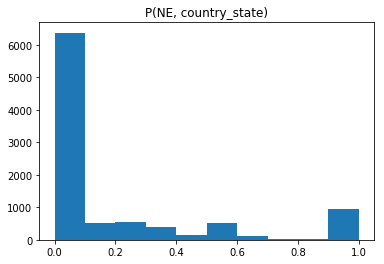

In [338]:
# histogram of P(NE, cooccur)
importance_prob_stat_names = ['P(NE, higher_pop_NE)', 'P(NE, higher_names_NE)', 'P(NE, country_state)']
importance_prob_stats = [combined_tag_data_NE_max_pop_cooccur, combined_tag_data_NE_max_names_cooccur, combined_tag_data_NE_country_state_cooccur]
for i, s in zip(importance_prob_stat_names, importance_prob_stats):
    plt.hist(s.loc[:, i].values)
    plt.title(i)
    plt.show()

Let's look for the top-k NEs by frequency for each event, then plot the $P(NE, more\_important\_cooccur)$ over time.

In [345]:
# combine all the data
combined_tag_data_NE_importance = pd.merge(combined_tag_data_NE_tf, combined_tag_data_NE_country_state_cooccur, on=['NE_fixed', 'data_name_fixed', 'date_stamp_bin'], how='outer')
combined_tag_data_NE_importance = pd.merge(combined_tag_data_NE_importance, combined_tag_data_NE_max_pop_cooccur, on=['NE_fixed', 'data_name_fixed', 'date_stamp_bin'], how='outer')
combined_tag_data_NE_importance = pd.merge(combined_tag_data_NE_importance, combined_tag_data_NE_max_names_cooccur, on=['NE_fixed', 'data_name_fixed', 'date_stamp_bin'], how='outer')
print('N=%d'%(combined_tag_data_NE_importance.shape[0]))
# add date stamp bin min
combined_tag_data_NE_importance = pd.merge(combined_tag_data_NE_importance, combined_tag_data_loc_time.drop_duplicates(['data_name_fixed', 'date_stamp_bin', 'date_stamp_bin_min'], inplace=False).loc[:, ['data_name_fixed', 'date_stamp_bin', 'date_stamp_bin_min']], on=['data_name_fixed', 'date_stamp_bin'])
display(combined_tag_data_NE_importance.head())

N=21845


,NE_fixed,data_name_fixed,date_stamp_bin,tf,"P(NE, country_state)","P(NE, higher_pop_NE)","P(NE, higher_names_NE)",date_stamp_bin_min
0,abbeville_county,irma,4,0.000004,0.000000,0.500000,0.500000,1.504963e+09
1,aberdeen,irma,4,0.000004,0.500000,0.500000,0.500000,1.504963e+09
2,adams,irma,4,0.000002,0.000000,0.000000,0.000000,1.504963e+09
3,adelaide,irma,4,0.000007,0.333333,0.666667,0.666667,1.504963e+09
4,aden,irma,4,0.000002,0.000000,0.000000,0.000000,1.504963e+09


processing florence data
top 0-5 NE florence,wilmington,bermuda,carolina,raleigh


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


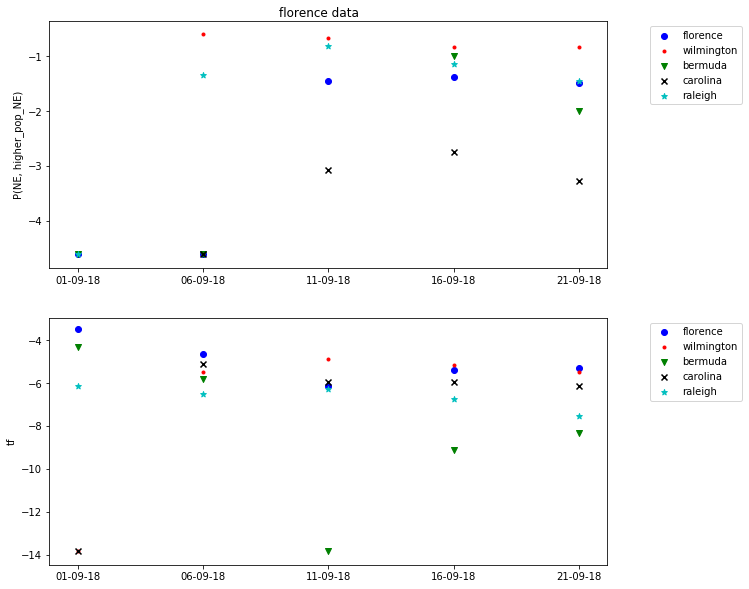

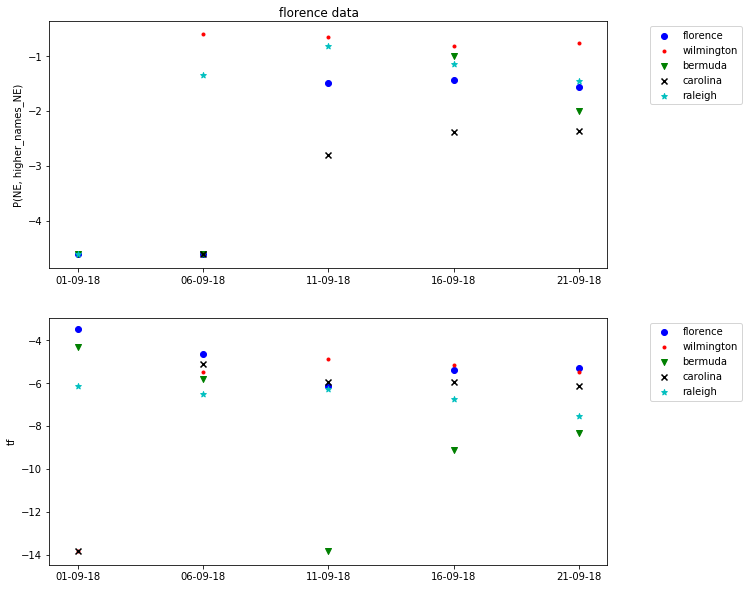

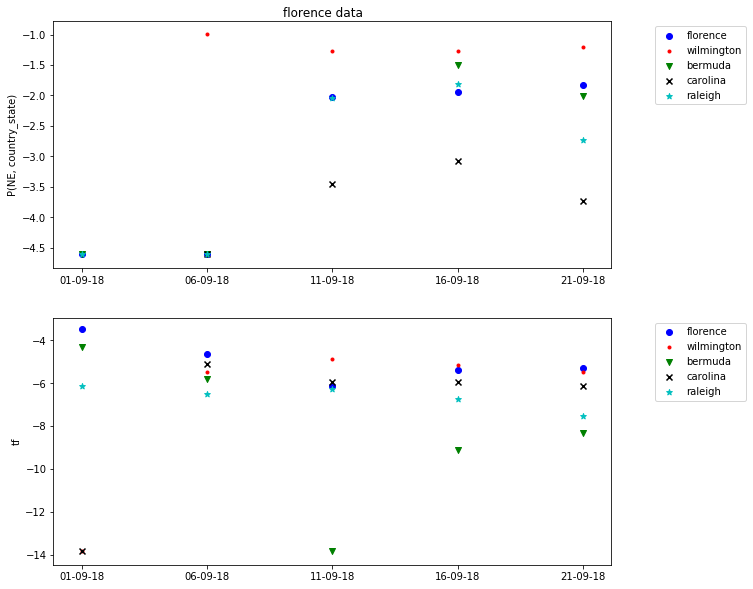

top 5-10 NE charleston,myrtle_beach,northwest,georgetown,conway


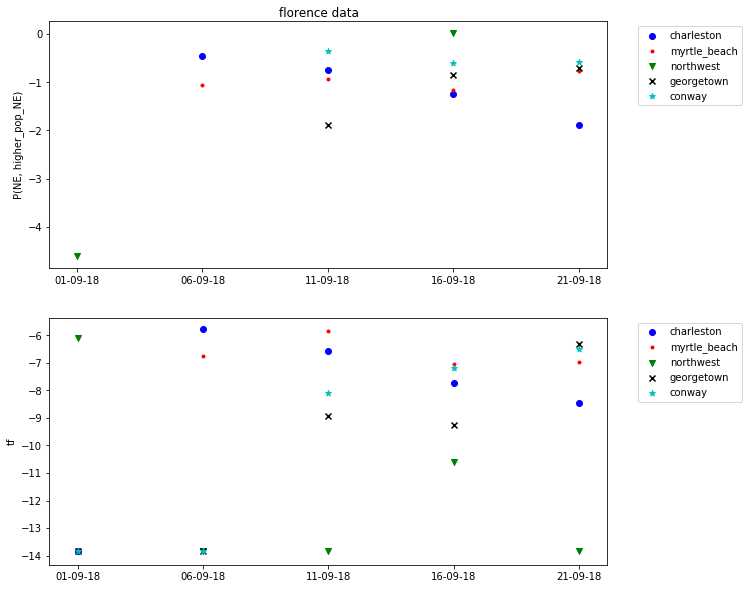

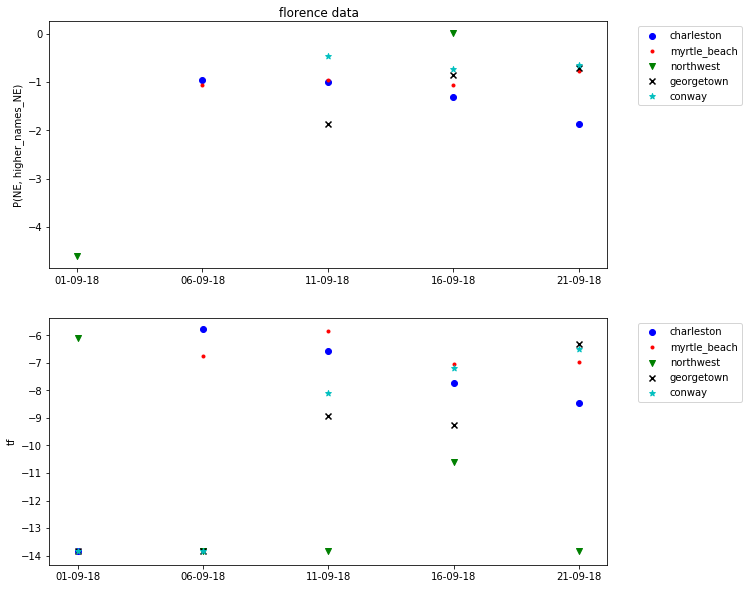

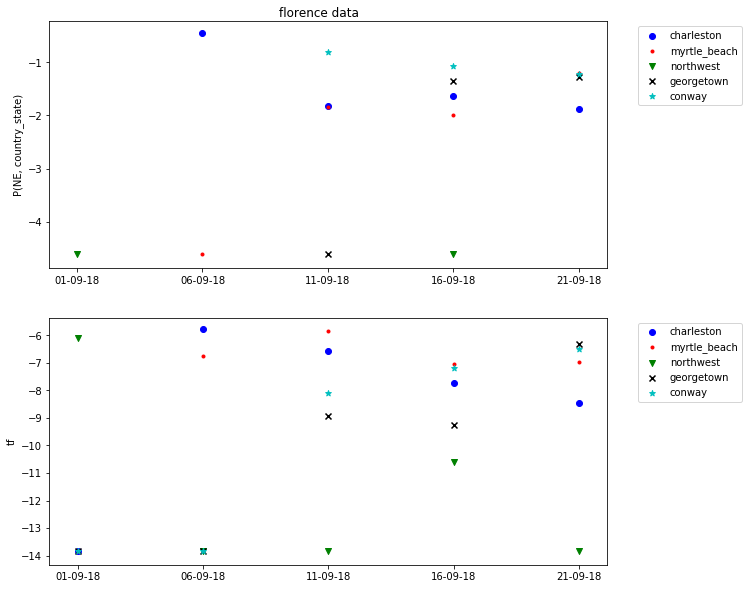

top 10-15 NE wrightsville_beach,jacksonville,morehead_city,atlanta,richmond


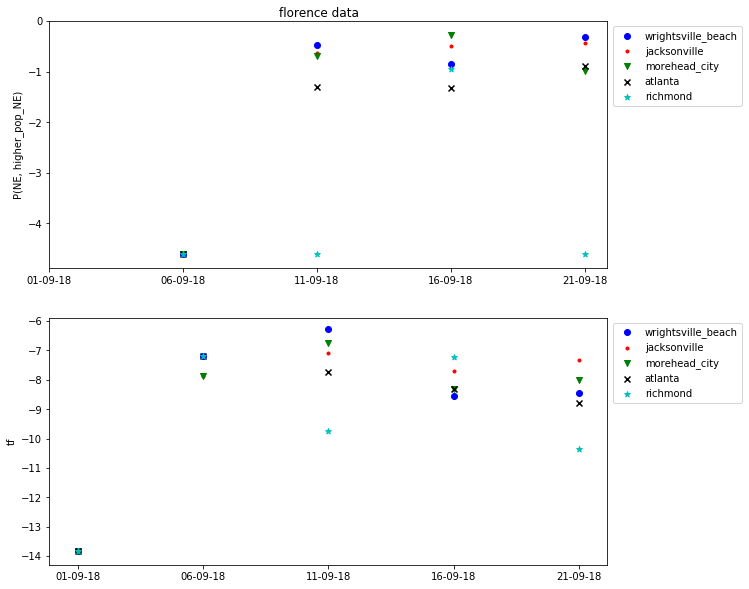

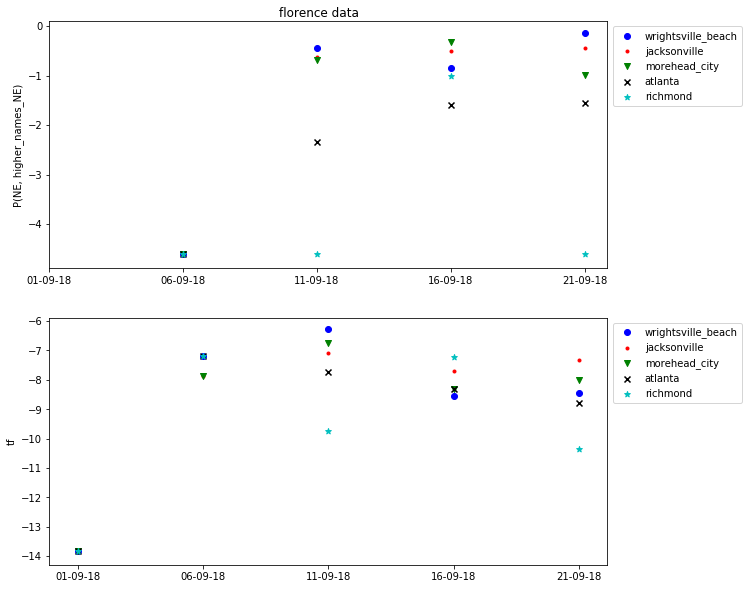

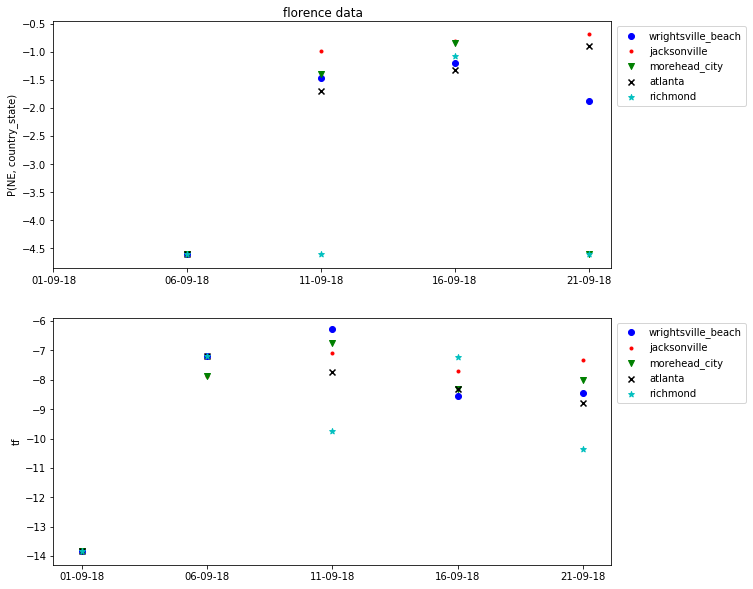

top 15-20 NE edisto_beach,horry_county,greenville,atlantic_beach,hurricane


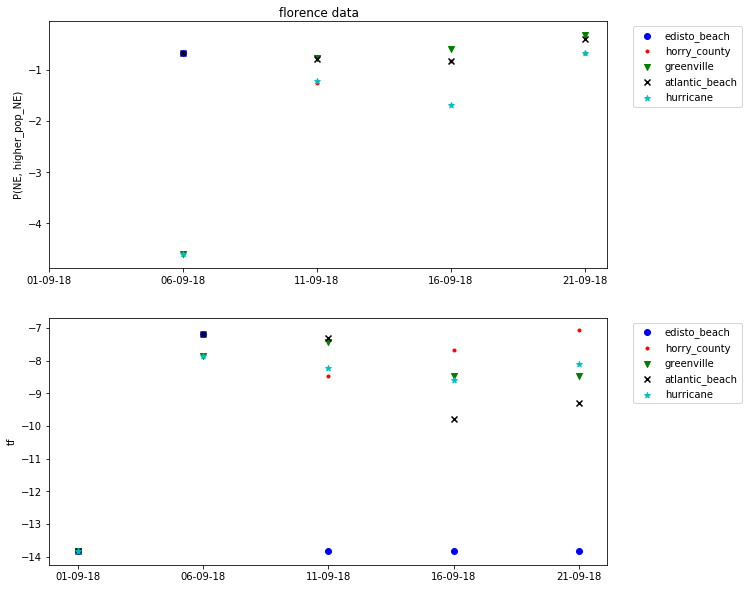

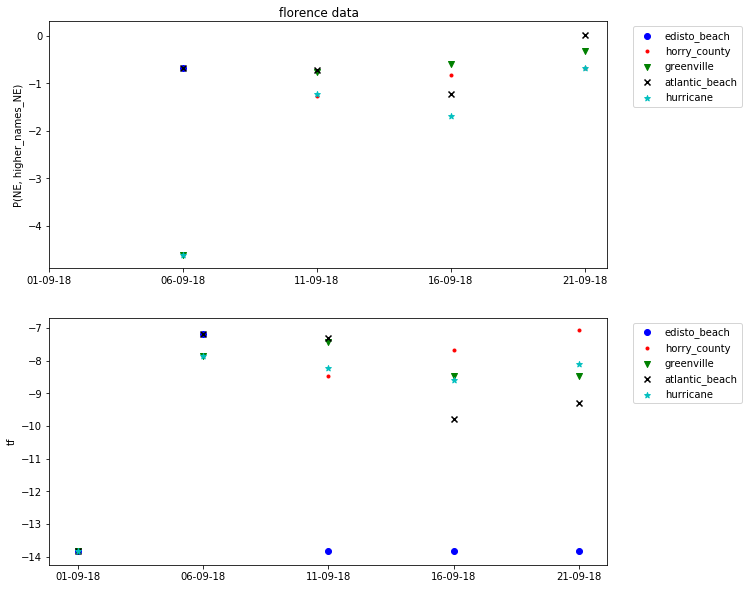

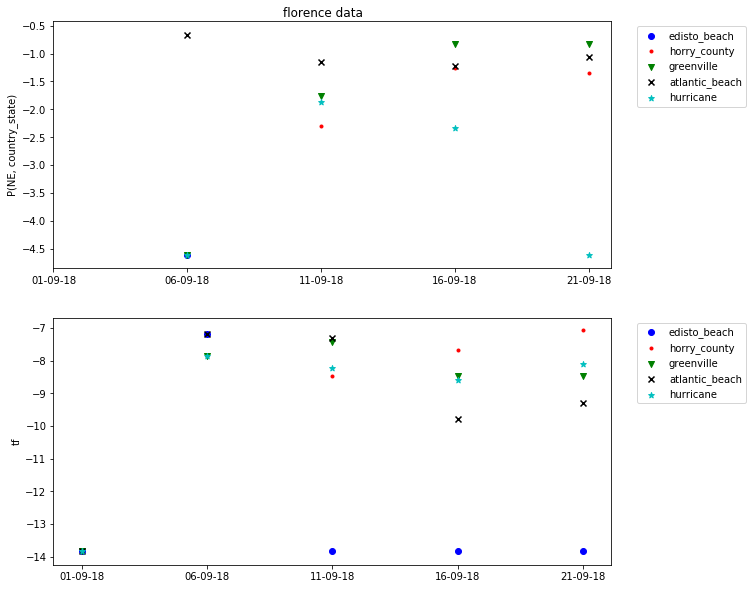

processing harvey data
top 0-5 NE houston,corpus_christi,rockport,austin,dallas


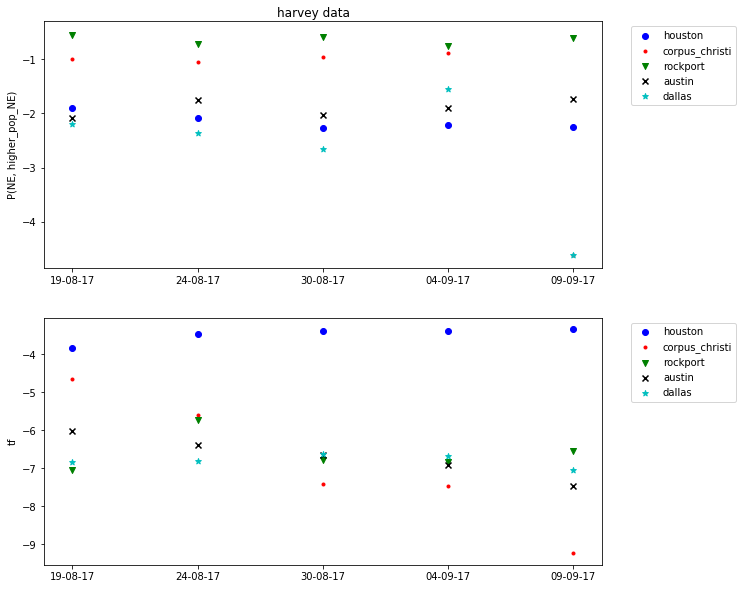

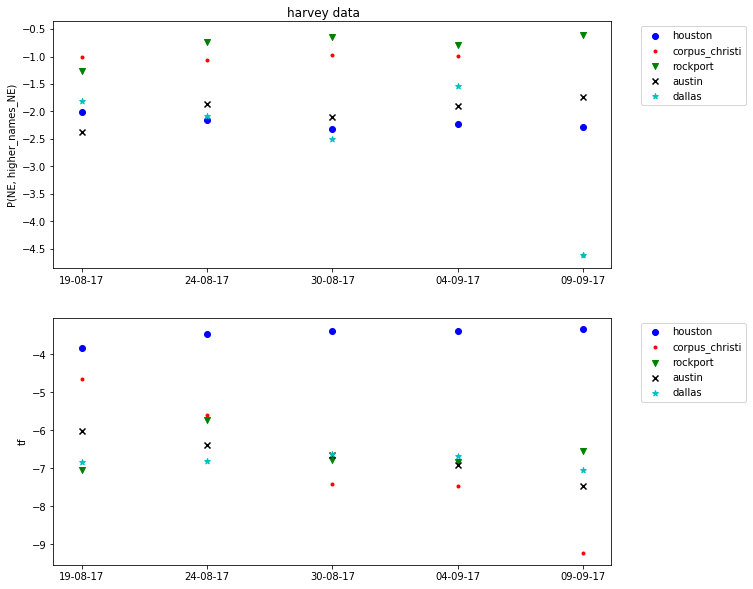

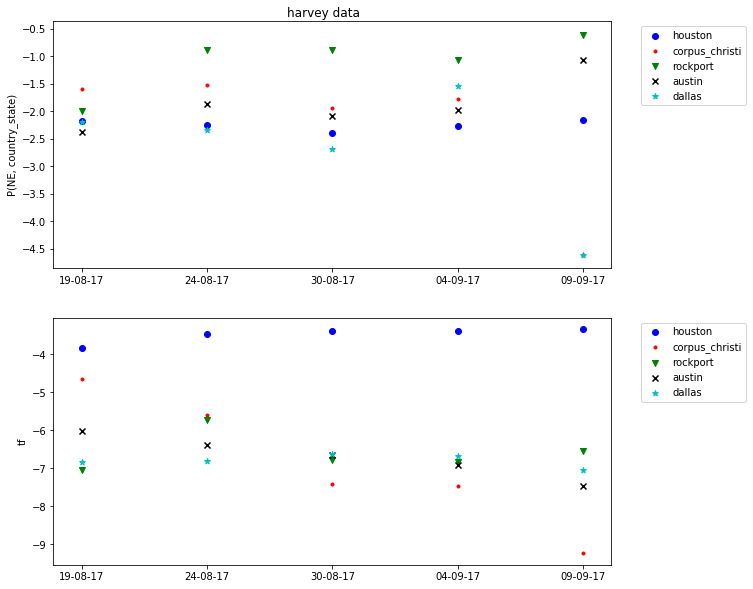

top 5-10 NE galveston,port_aransas,port_arthur,harvey,harris_county


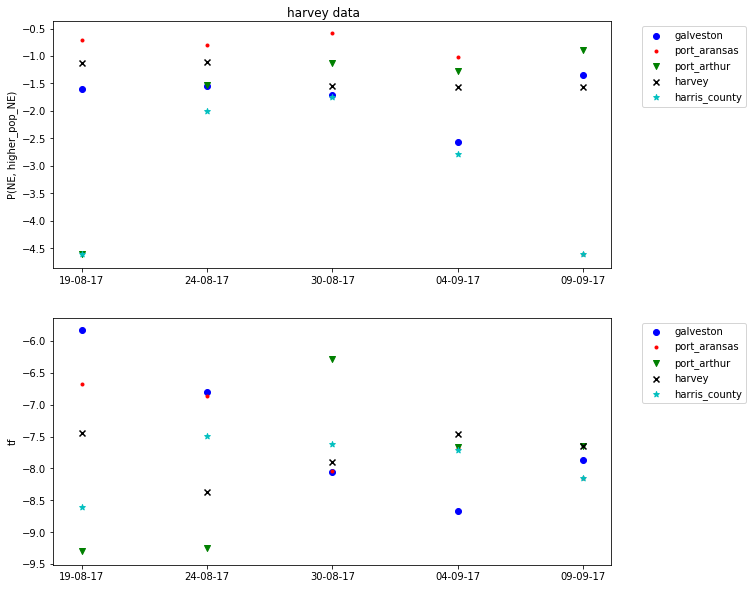

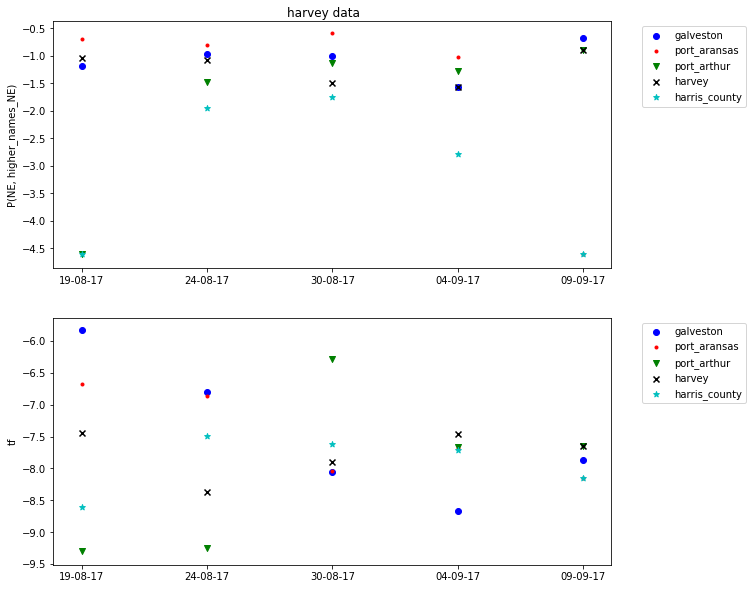

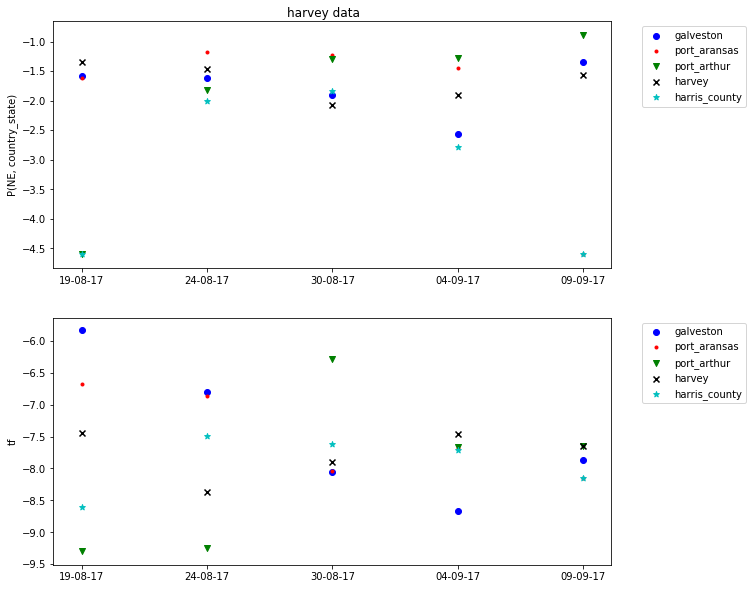

top 10-15 NE aransas_pass,brownsville,victoria,nola,sandy


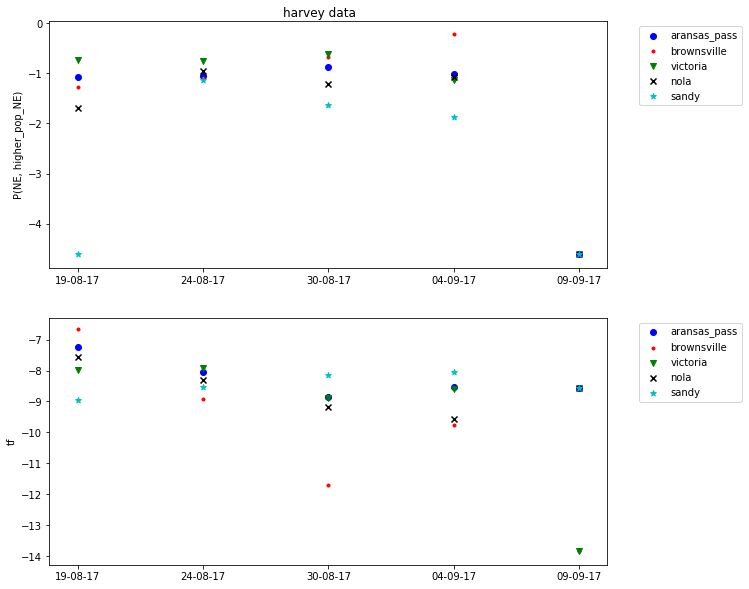

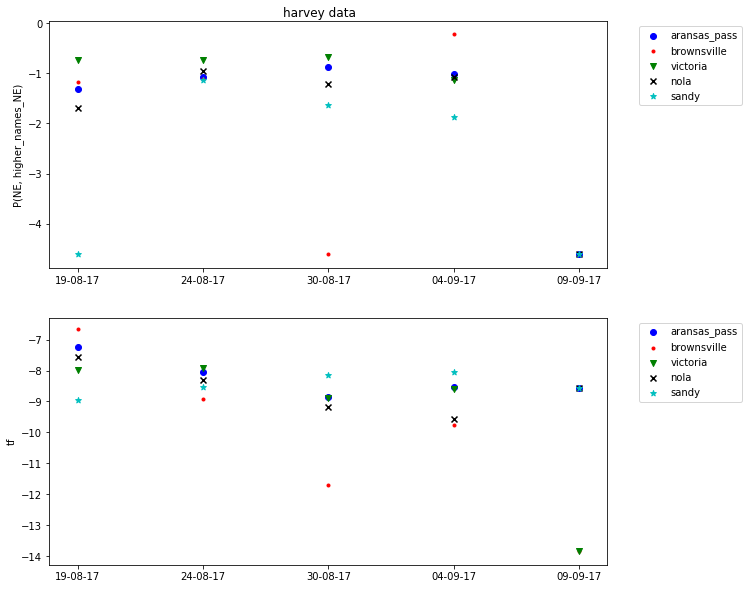

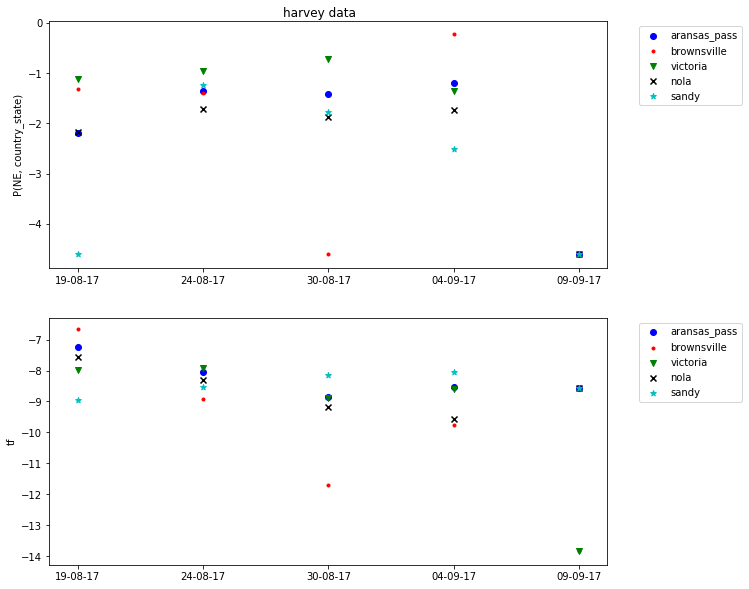

top 15-20 NE hurricane,senate,dickinson,center,kingwood


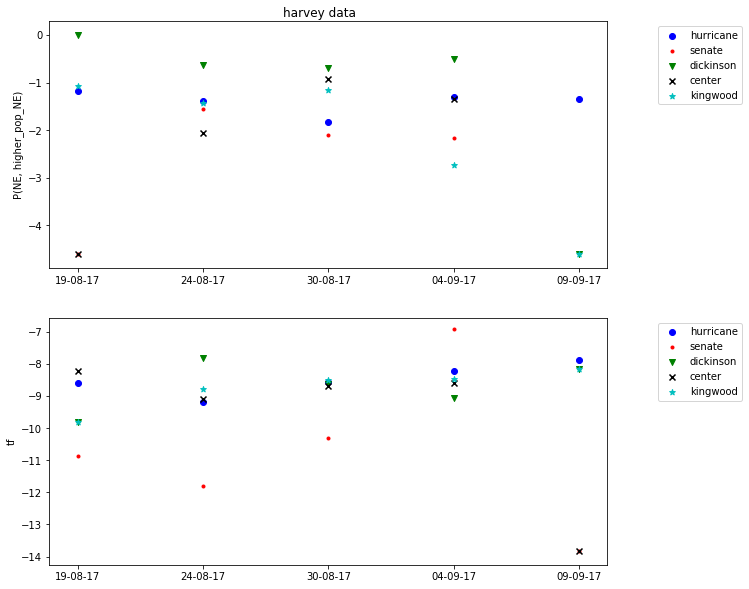

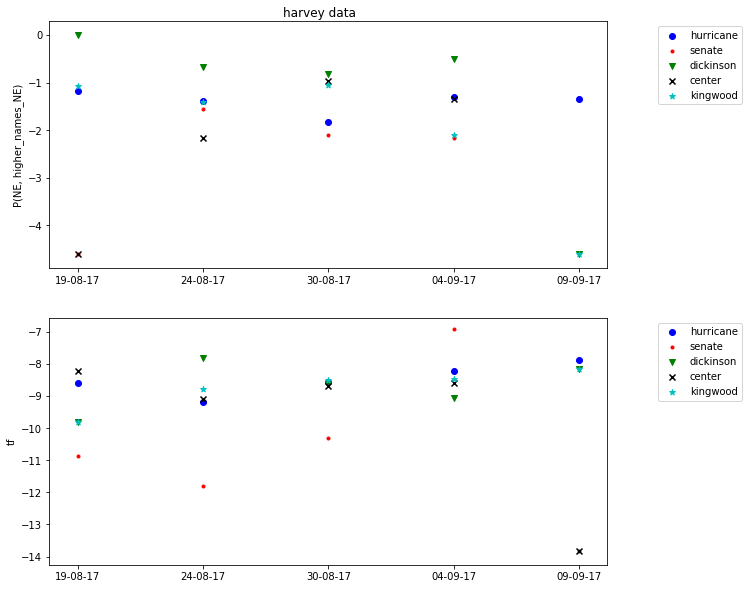

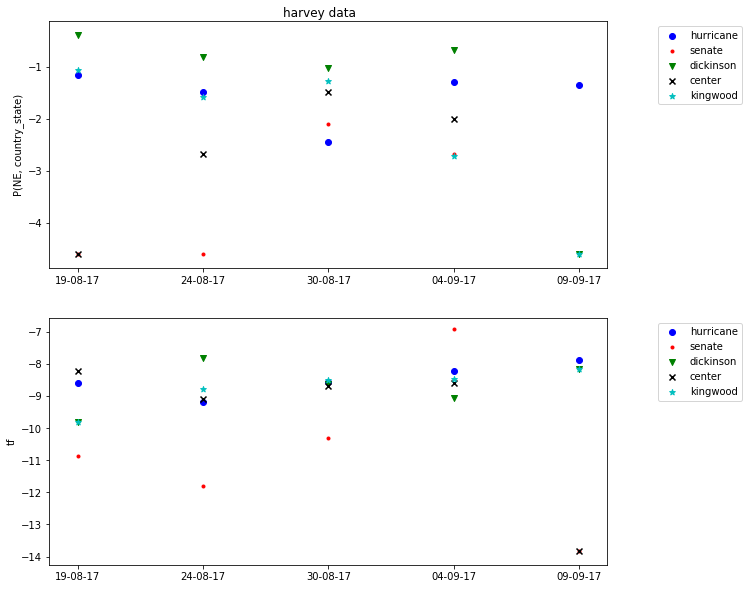

processing irma data
top 0-5 NE houston,tampa,carolina,gulf,charleston


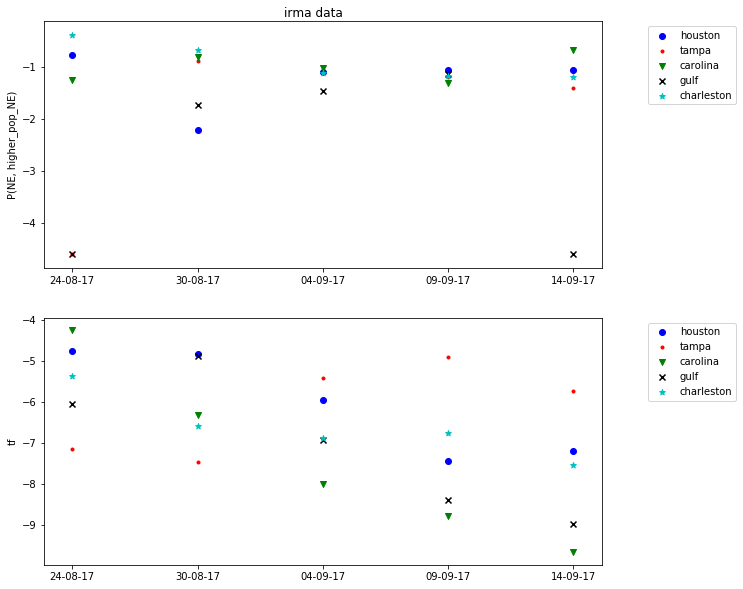

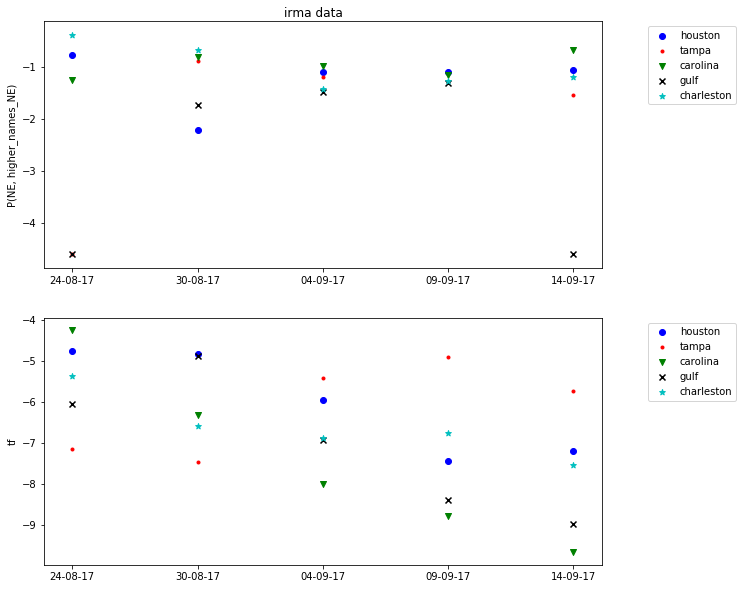

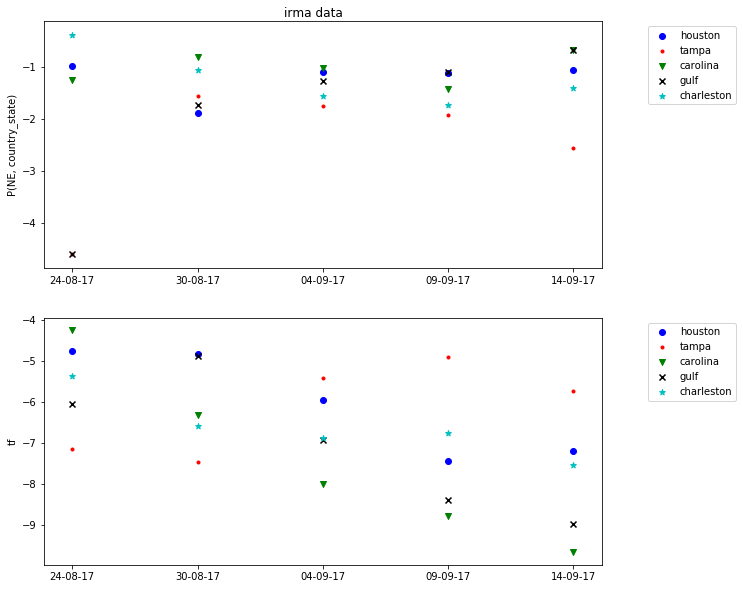

top 5-10 NE jacksonville,atlanta,anguilla,hurricane,miami_beach


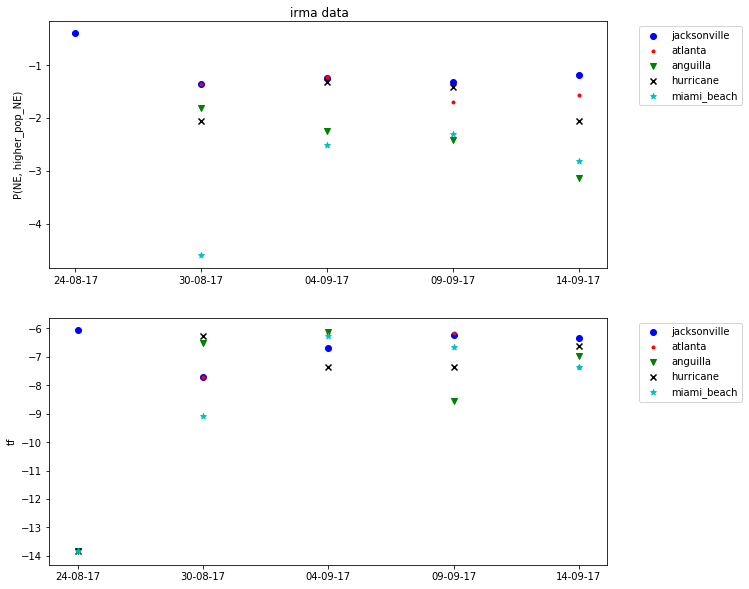

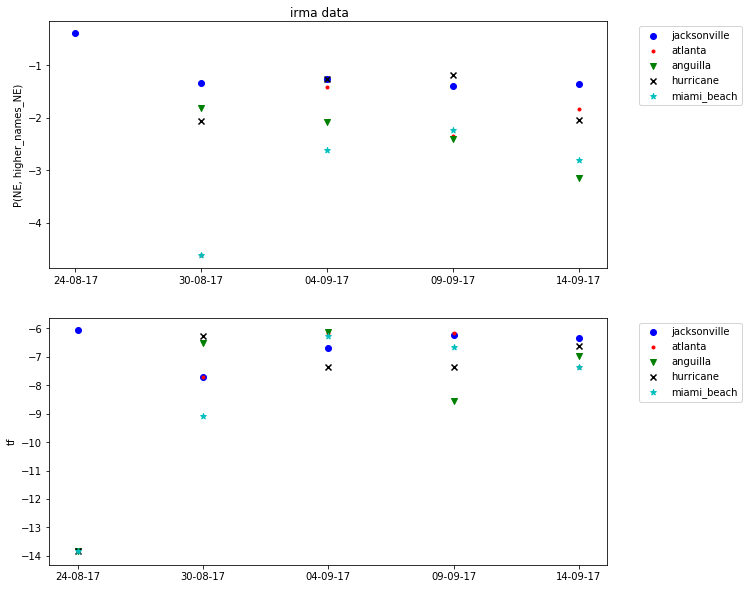

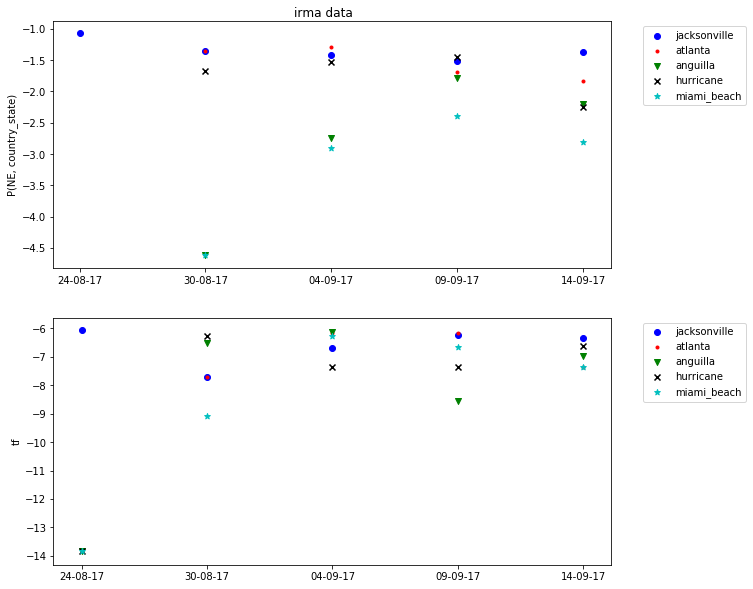

top 10-15 NE marco_island,santee,jamestown,bermuda,raleigh


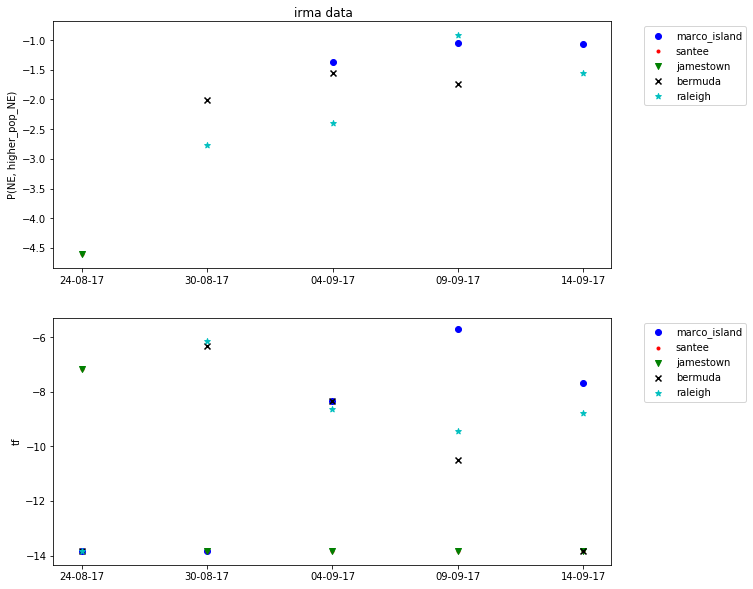

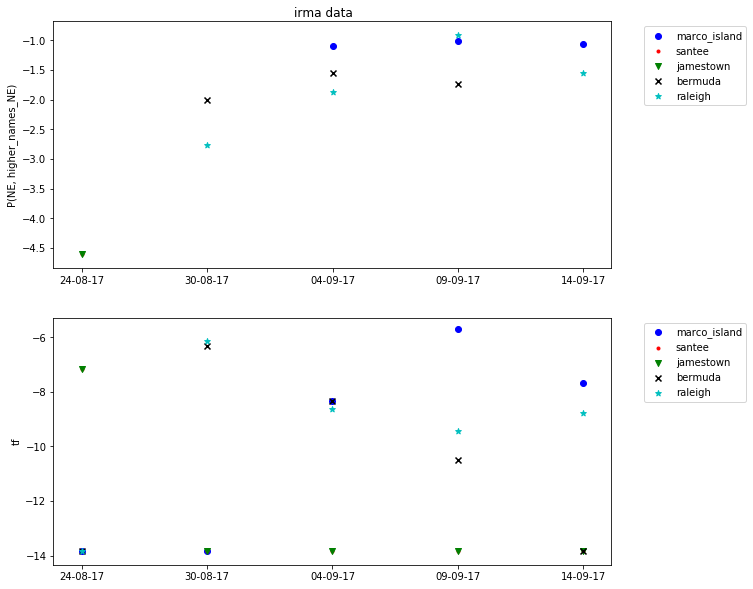

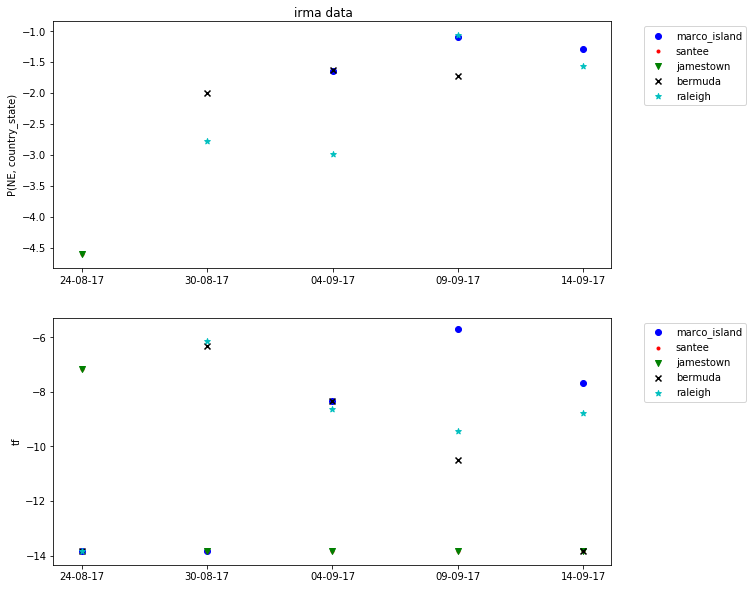

top 15-20 NE alert,savannah,tallahassee,palm_beach,wilmington


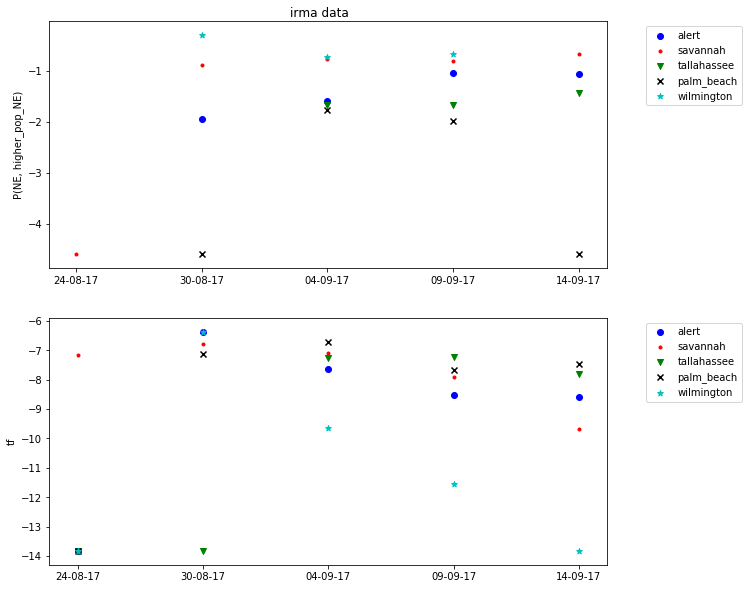

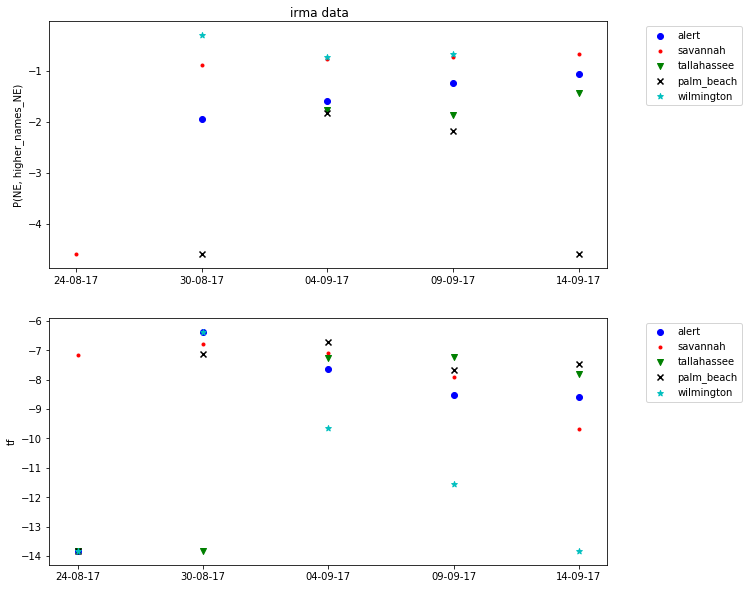

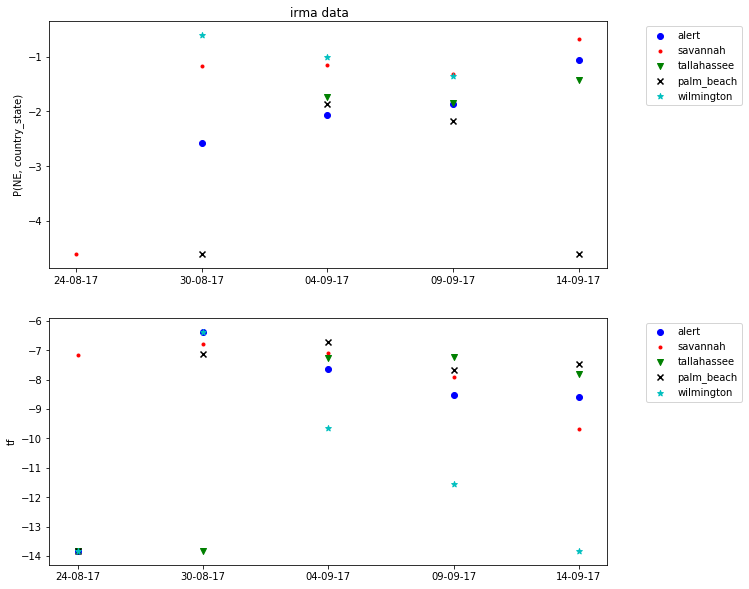

processing maria data
top 0-5 NE san_juan,vieques,arecibo,utuado,caguas


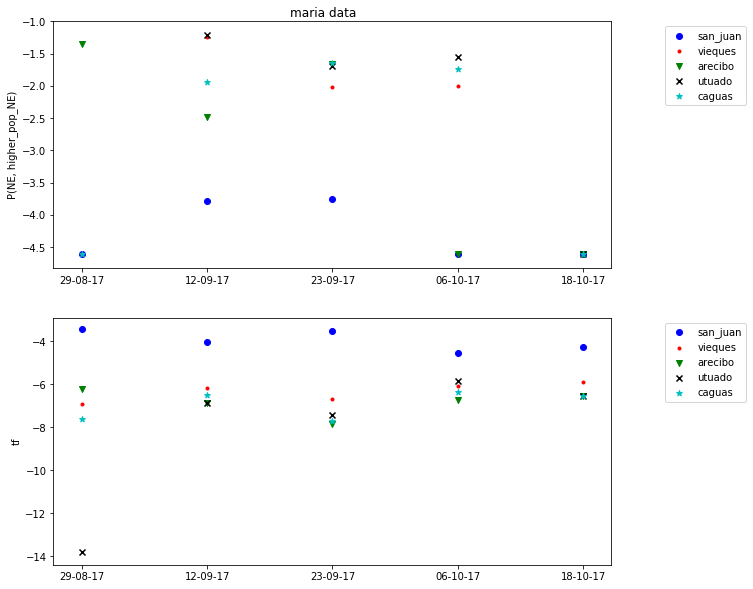

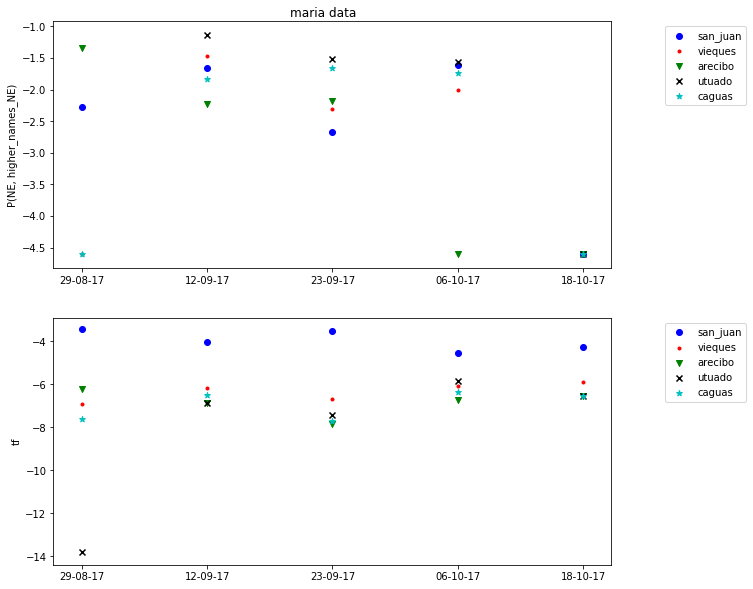

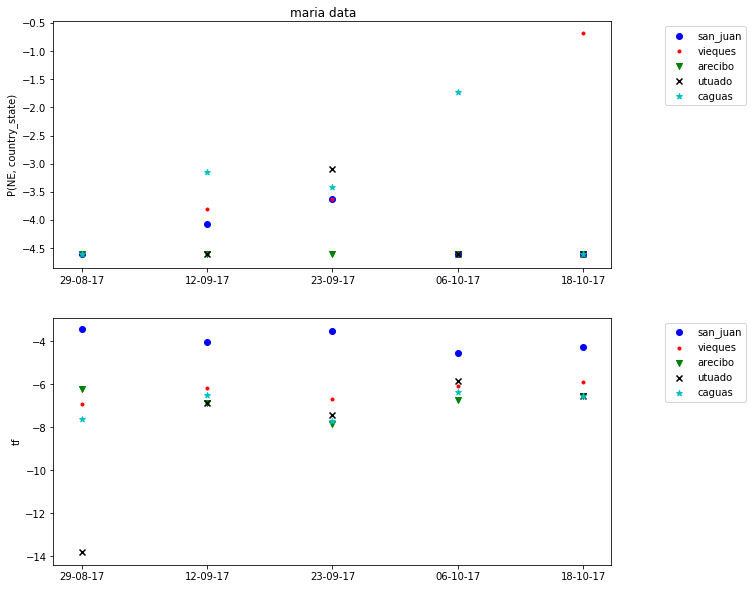

top 5-10 NE ponce,bayamon,carolina,santa_maria,guaynabo


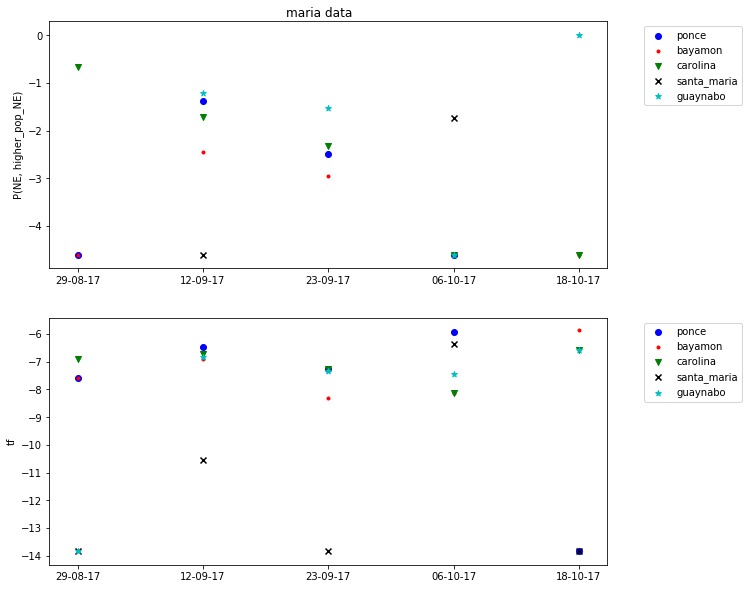

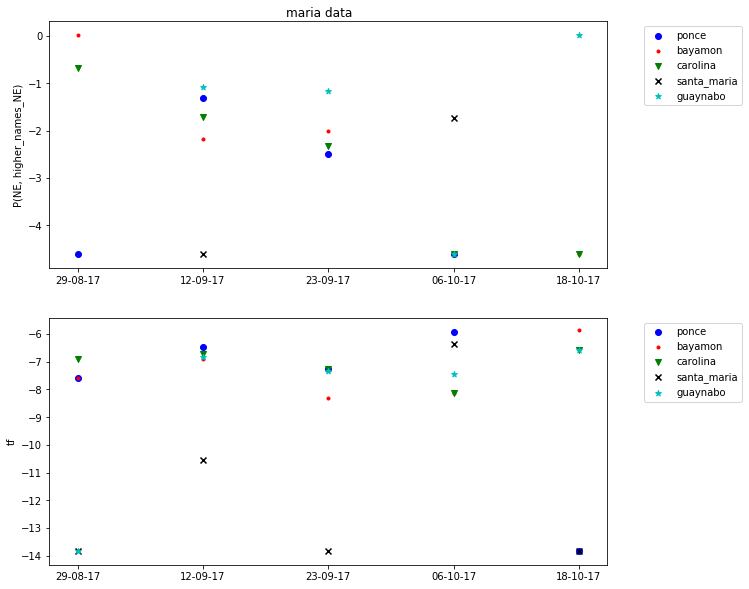

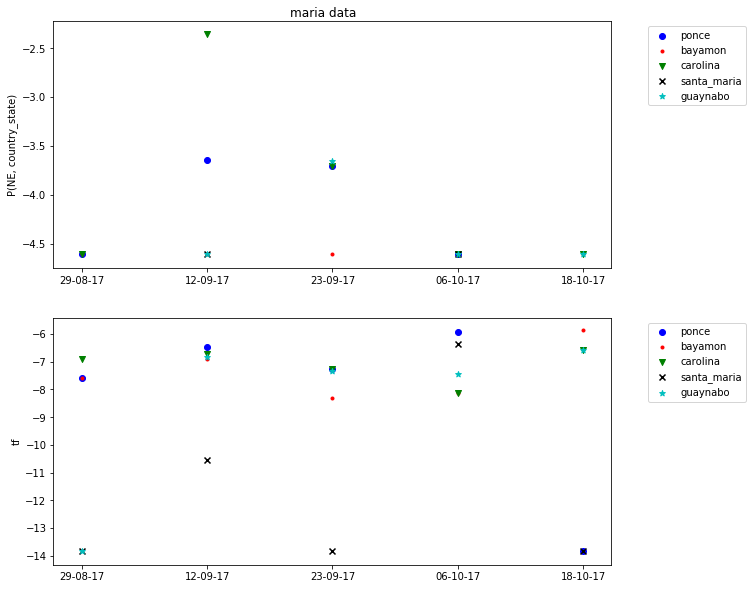

top 10-15 NE cana,santiago,barcelona,naranjito,culebra


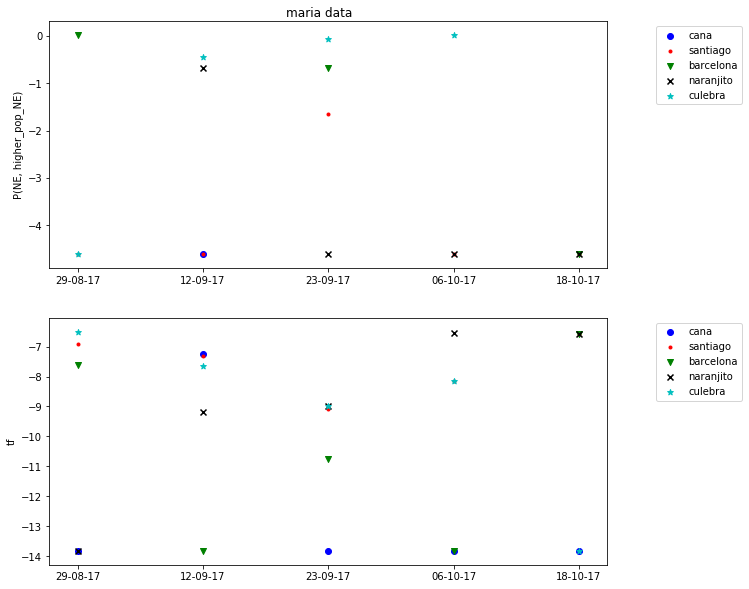

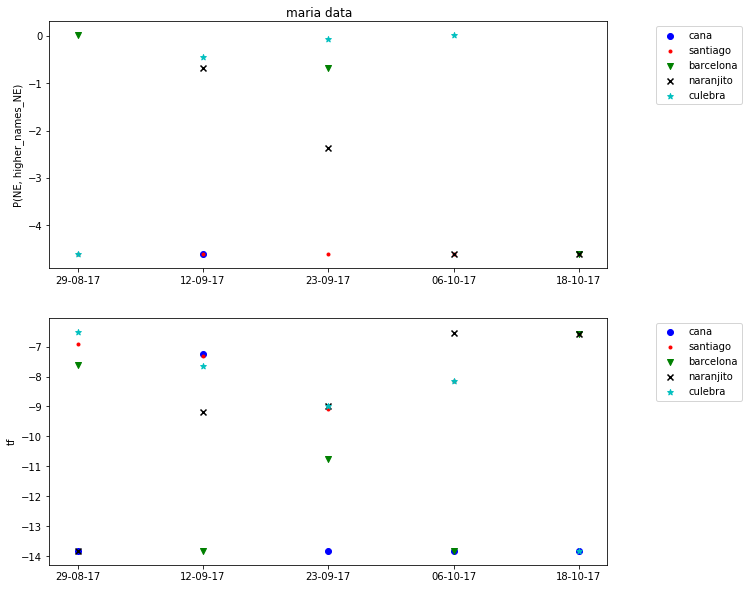

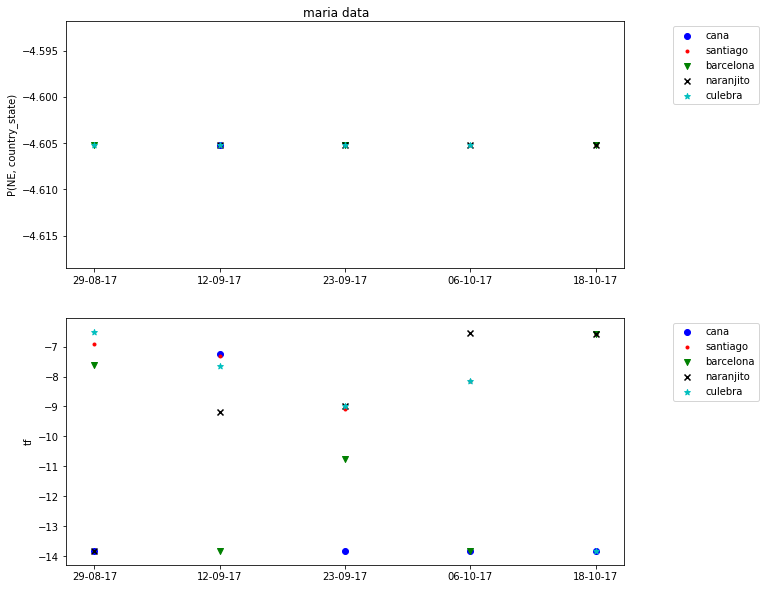

top 15-20 NE cabo_rojo,madrid,union,aguadilla,manati


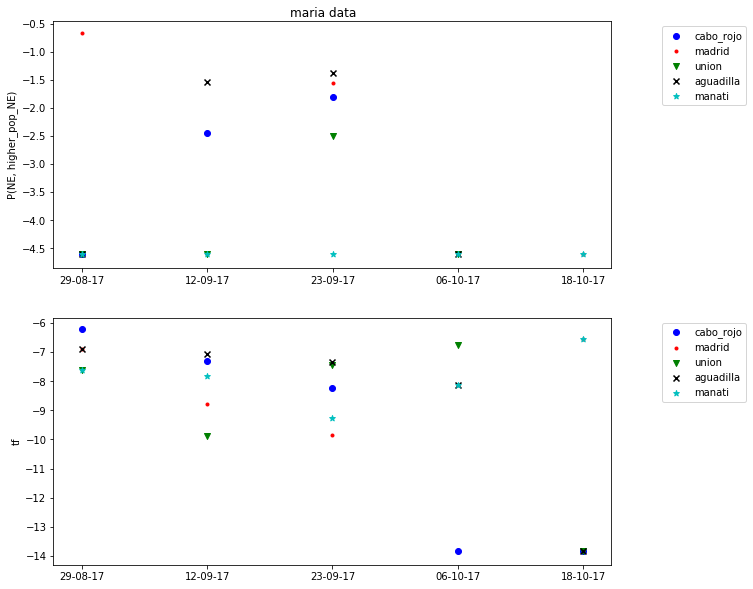

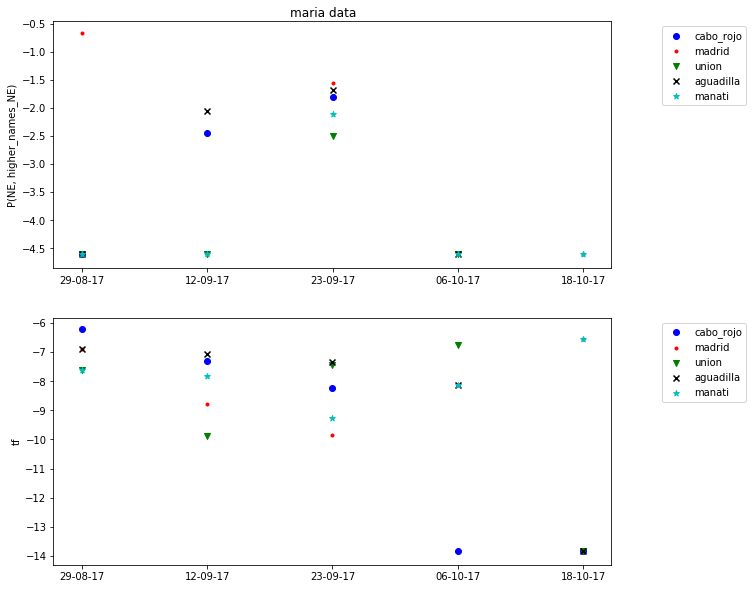

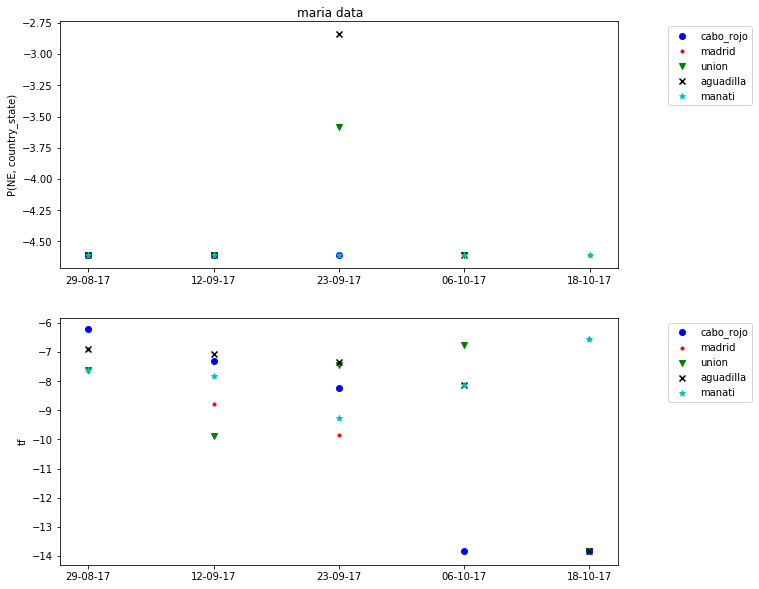

processing michael data
top 0-5 NE mexico_beach,tallahassee,panhandle,panama_city_beach,bay_county


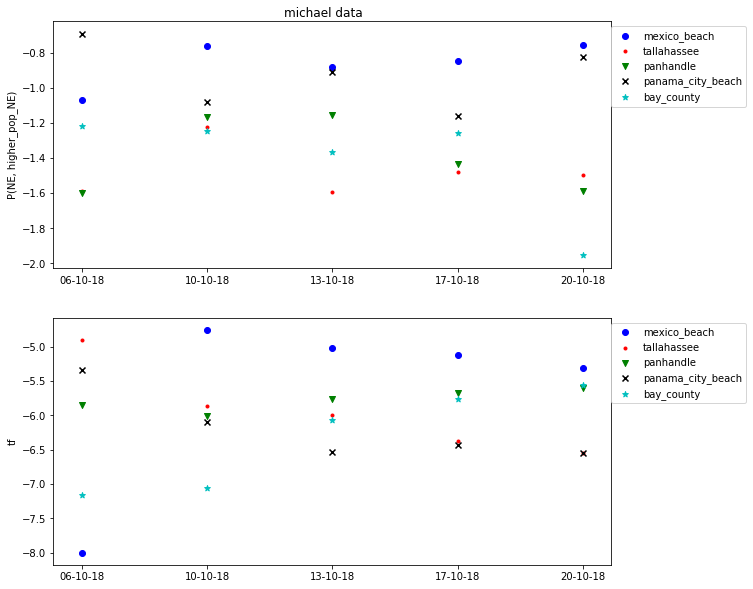

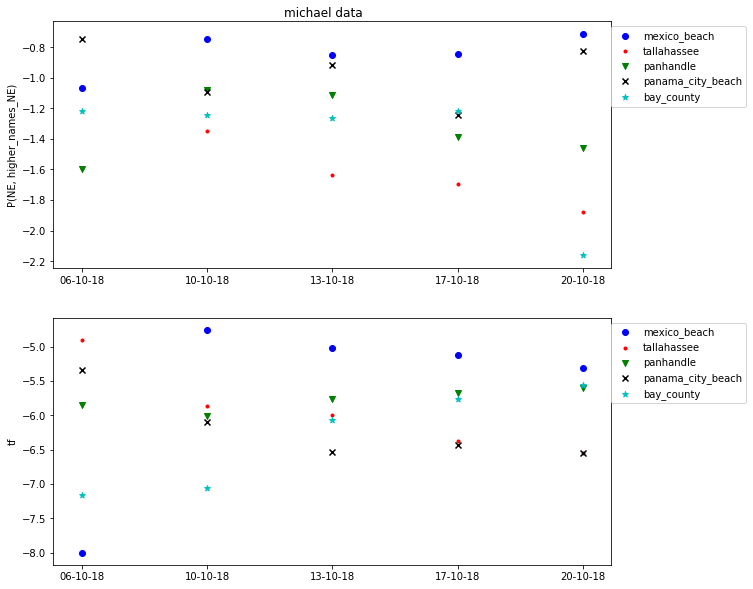

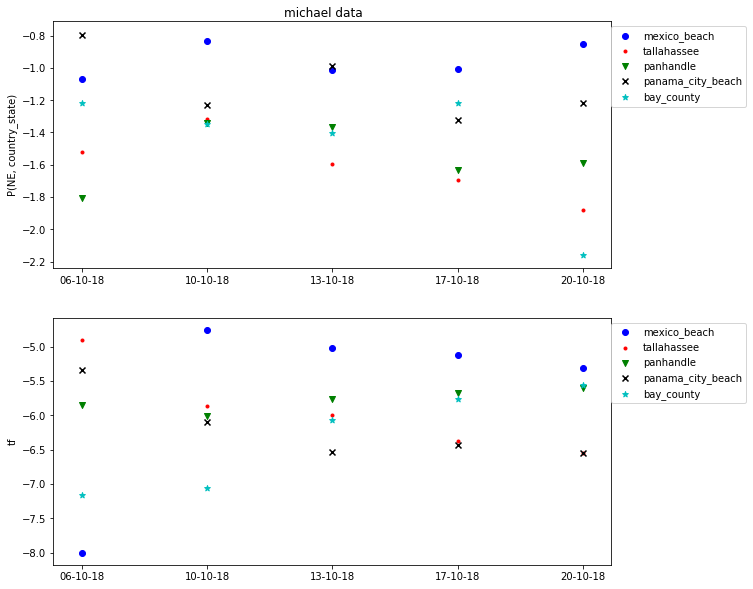

top 5-10 NE lynn_haven,gulf,gulf_county,bay,jackson_county


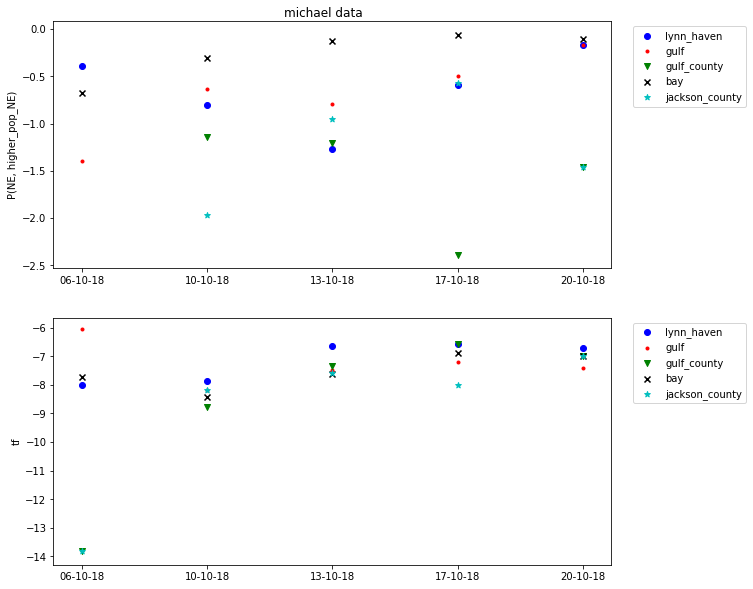

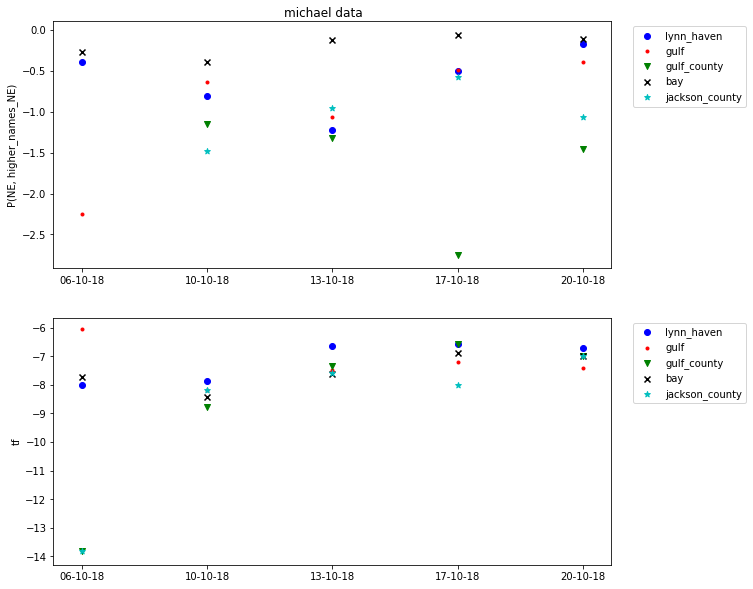

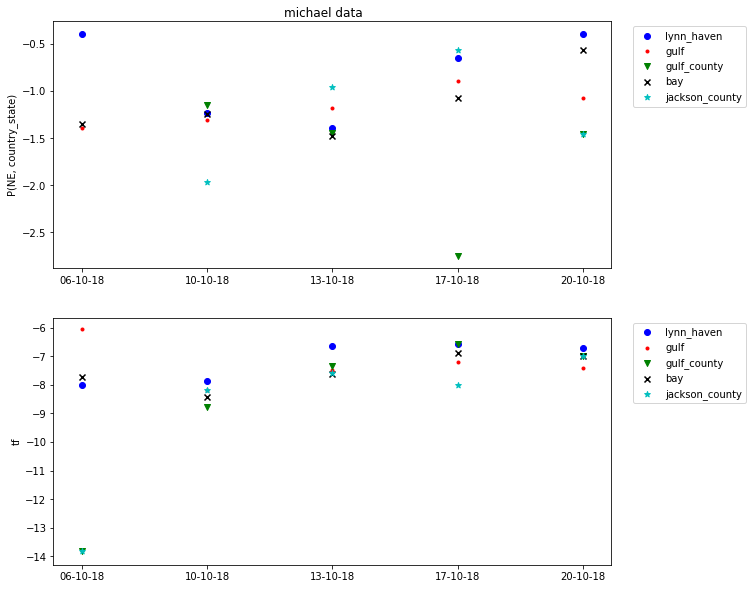

top 10-15 NE hurricane,atlanta,marianna,destin,calhoun


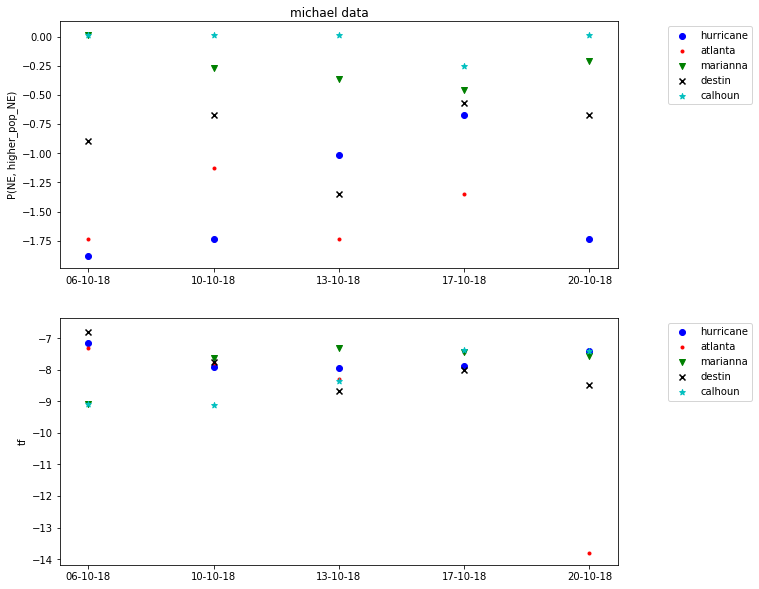

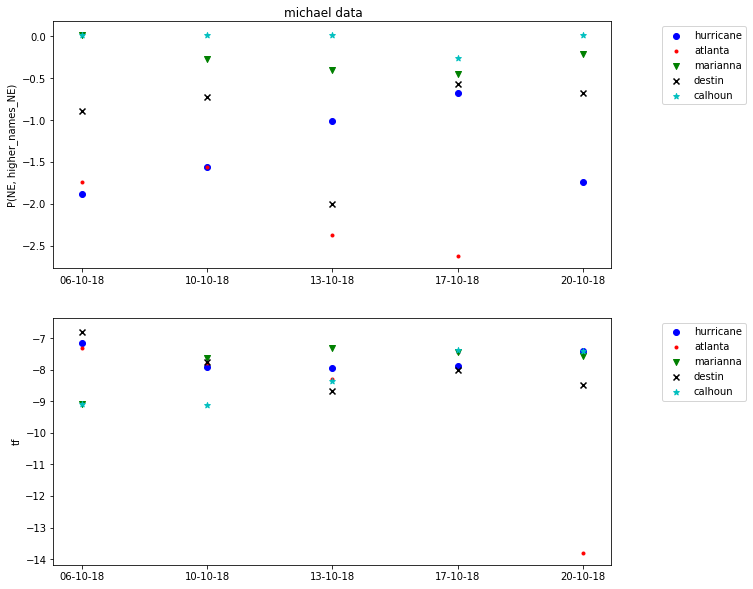

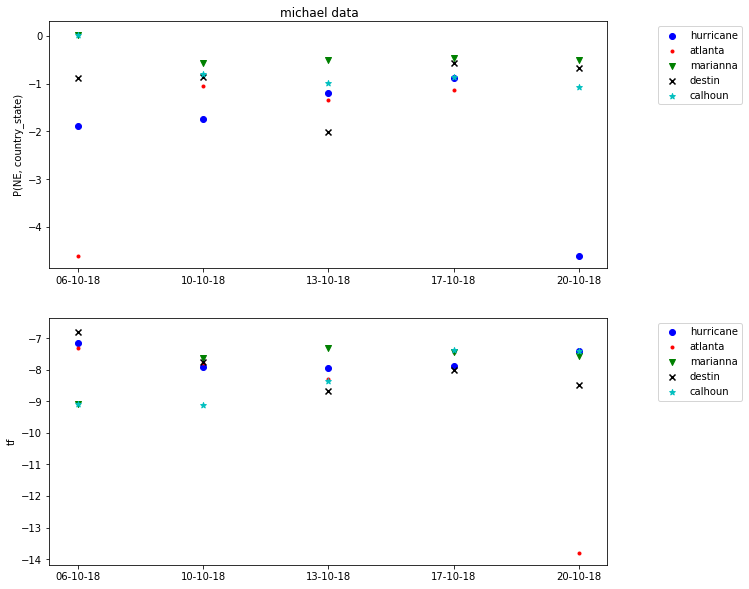

top 15-20 NE dunwoody,tampa,white_house,calhoun_county,gadsden_county


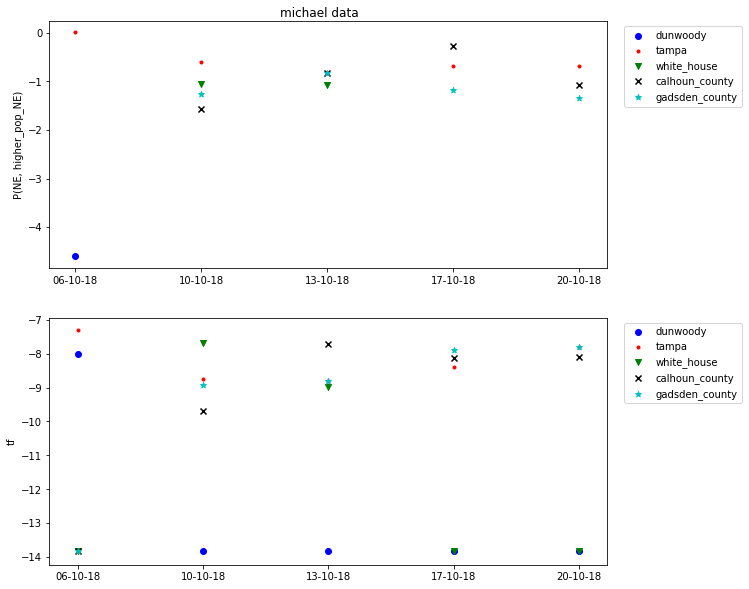

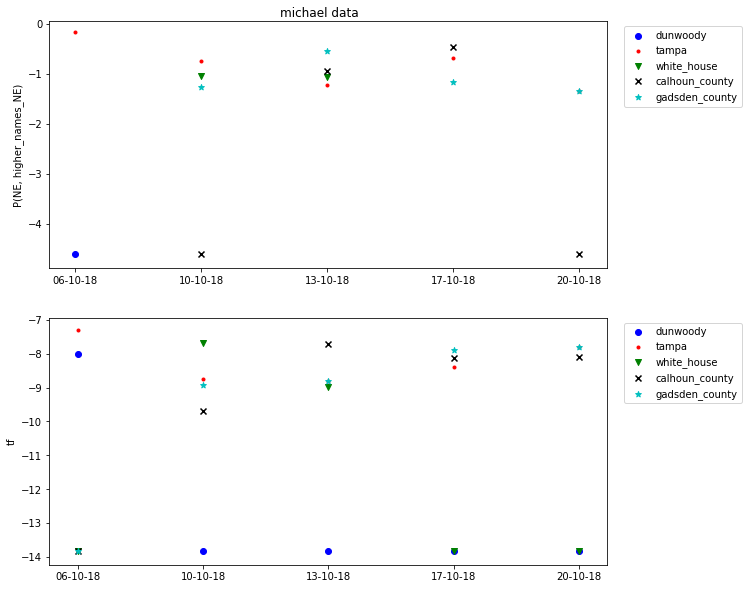

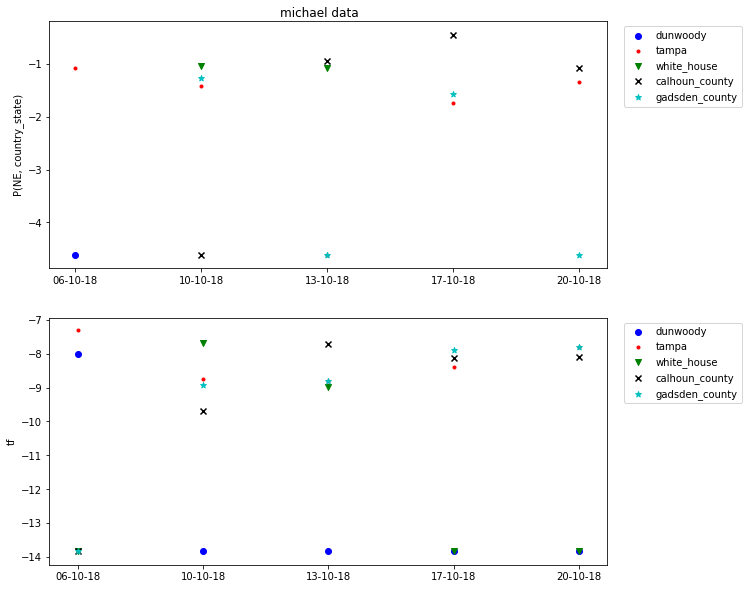

In [391]:
from datetime import datetime
from itertools import cycle
top_k = 5
top_K = 20
top_k_range = np.linspace(0, top_K, int(top_K/top_k)+1).astype(int)
top_k_range = list(zip(top_k_range[:-1], top_k_range[1:]))
context_state_names = ['P(NE, higher_pop_NE)', 'P(NE, higher_names_NE)', 'P(NE, country_state)']
freq_stat = 'tf'
freq_smooth = 1e-6
prob_smooth = 1e-2
time_var = 'date_stamp_bin'
for data_name_i, data_i in combined_tag_data_NE_importance.groupby('data_name_fixed'):
    print('processing %s data'%(data_name_i))
    for top_k_low, top_k_high in top_k_range:
    # compute top-k NE
        top_k_NE = list(data_i.groupby('NE_fixed').apply(lambda x: x.loc[:, freq_stat].mean()).sort_values(inplace=False, ascending=False)[top_k_low:top_k_high].index)
        print('top %d-%d NE %s'%(top_k_low, top_k_high, ','.join(top_k_NE)))
        X_i = data_i.loc[:, time_var].unique()
        X_i_labs = [datetime.strftime(datetime.fromtimestamp(x), '%d-%m-%y') for x in data_i.loc[:, 'date_stamp_bin_min'].unique()]
        for context_state_name_i in context_state_names:
            fig, axs = plt.subplots(2,1, figsize=(10, 10))
            ax_i, ax_f = axs
            colors = cycle(['b', 'r', 'g', 'k', 'c'])
            markers = cycle(['o', '.', 'v', 'x', '*', 's'])
            for NE_k in top_k_NE:
                data_i_k = data_i[data_i.loc[:, 'NE_fixed']==NE_k]
                color_k = next(colors)
                marker_k = next(markers)
                X_i_k = data_i_k.loc[:, time_var].values
                ## plot P(NE, context)
                prob_i_k = data_i_k.loc[:, context_state_name_i].values
                # log-transform?
                prob_i_k = np.log(prob_i_k+prob_smooth)
                ax_i.scatter(X_i_k, prob_i_k, label=NE_k, c=color_k, marker=marker_k)
                ## plot frequency
                # fill NA time bins with 0
                freq_i_k = pd.Series(data_i_k.loc[:, 'tf'].values, index=data_i_k.loc[:, time_var].values)
                freq_i_k = freq_i_k.loc[X_i].fillna(0, inplace=False)
                # log-transform
                freq_i_k = np.log(freq_i_k+freq_smooth)
                ax_f.scatter(X_i, freq_i_k, label=NE_k, c=color_k, marker=marker_k)
            ax_i.set_ylabel(context_state_name_i)
            ax_f.set_ylabel('tf')
            ax_i.set_xticks(X_i)
            ax_i.set_xticklabels(X_i_labs)
            ax_f.set_xticks(X_i)
            ax_f.set_xticklabels(X_i_labs)
            ax_i.legend(loc='upper right', bbox_to_anchor=[1.25, 1.])
            ax_f.legend(loc='upper right', bbox_to_anchor=[1.25, 1.])
            plt.suptitle('%s data'%(data_name_i), y=0.9)
            plt.show()